# Bank Churn Prediction
by Michele Casalgrandi

# Background
Customer churn is a concern for all businesses that provide financial services.  In this case, a bank wants to be able to identify customers at risk of leaving and joining another service provider.

# Objective
Given a bank customer predict whether the customer will leave or not.

# Data Dictionary
* CustomerId: Unique ID which is assigned to each customer
* Surname: Last name of the customer 
* CreditScore: It defines the credit history of the customer.  
* Geography: A customer’s location    
* Gender: It defines the Gender of the customer   
* Age: Age of the customer     
* Tenure: Number of years for which the customer has been with the bank
* NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
* Balance: Account balance
* HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
* EstimatedSalary: Estimated salary 
* isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active member in the sense, using bank products regularly, making transactions, etc )
* Exited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values:  
    0=No ( Customer did not leave the bank )  
    1=Yes ( Customer left the bank )

#### Import necessary libraries and load data 

In [100]:
# import libraries
import numpy as np
import pandas as pd
from sklearn import metrics, model_selection
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

# oversample and undersample
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

random_seed = 1
np.random.seed(random_seed)

In [101]:
data_file = 'bank.csv'
df = pd.read_csv(data_file)

# get shape
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in the data set.")

There are 10000 rows and 14 columns in the data set.


In [102]:
# list columns
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

In [103]:
# check the data type of each column
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

There three columns stored as object: 'Surname', 'Geography' and 'Gender'.

The remaining columns are stored as numeric.  

However, 'HasCrCard', 'IsActiveMember' and 'Exited' are categorical. 

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


There are no missing values.

In [105]:
# check for duplicates
df.duplicated().sum()

0

There are no duplicates.

In [106]:
# check unique values
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [107]:
# view a sample of the data
df.sample(12)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9953,9954,15655952,Burke,550,France,Male,47,2,0.000,2,1,1,97057.280,0
3850,3851,15775293,Stephenson,680,France,Male,34,3,143292.950,1,1,0,66526.010,0
4962,4963,15665088,Gordon,531,France,Female,42,2,0.000,2,0,1,90537.470,0
3886,3887,15720941,Tien,710,Germany,Male,34,8,147833.300,2,0,1,1561.580,0
5437,5438,15733476,Gonzalez,543,Germany,Male,30,6,73481.050,1,1,1,176692.650,0
8517,8518,15671800,Robinson,688,France,Male,20,8,137624.400,2,1,1,197582.790,0
2041,2042,15709846,Yeh,840,France,Female,39,1,94968.970,1,1,0,84487.620,0
1989,1990,15622454,Zaitsev,695,Spain,Male,28,0,96020.860,1,1,1,57992.490,0
1933,1934,15815560,Bogle,666,Germany,Male,74,7,105102.500,1,1,1,46172.470,0
9984,9985,15696175,Echezonachukwu,602,Germany,Male,35,7,90602.420,2,1,1,51695.410,0


Observations:
* `RowNumber` is same as index but offset by 1. 
    This column doesn't add any value and will be dropped
* `CustomerId` is unique for all rows and has no predictive value.  
    It will be dropped.
* `Surname` has duplicates but none have same CustomerId, so they are distinct customers.  
    Surname having predictive value is extremely low, we will drop this column.

In [108]:
target_class = 'Exited'

cols_to_drop = ['RowNumber', 'CustomerId', 'Surname']

# drop columns
bank = df.drop(columns=cols_to_drop, axis=1)

In [109]:
bank.sample(12)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
9203,773,Spain,Male,51,4,0.000,2,0,0,123587.830,1
7827,605,France,Male,41,10,0.000,2,0,1,97213.090,0
3620,773,France,Male,41,4,0.000,2,1,1,24924.920,0
5919,645,Spain,Male,49,8,0.000,2,1,0,162012.600,0
72,657,Spain,Female,37,0,163607.180,1,0,1,44203.550,0
4685,537,Spain,Male,42,1,190569.230,1,0,1,127154.800,0
8684,813,Germany,Male,27,6,111348.150,1,1,0,46422.460,0
943,675,Germany,Female,29,8,121326.420,1,1,0,133457.520,0
2055,469,Germany,Male,38,9,113599.420,1,0,0,11950.290,0
9021,655,Germany,Female,61,2,183997.700,2,1,1,161217.180,0


It seems many records have 0.0 as balance.

In [110]:
bank['Balance'][bank['Balance'] < 0.1].count()

3617

About 36% of customers have zero balance.

In [111]:
# set numerical format for pandas
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# list categorical stored as numeric
non_object_categ = ['HasCrCard','IsActiveMember','Exited']

# get numerical data statistics
bank.drop(columns=non_object_categ, axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.000,650.529,96.653,350.000,584.000,652.000,718.000,850.000
Age,10000.000,38.922,10.488,18.000,32.000,37.000,44.000,92.000
Tenure,10000.000,5.013,2.892,0.000,3.000,5.000,7.000,10.000
Balance,10000.000,76485.889,62397.405,0.000,0.000,97198.540,127644.240,250898.090
NumOfProducts,10000.000,1.530,0.582,1.000,1.000,1.000,2.000,4.000
EstimatedSalary,10000.000,100090.240,57510.493,11.580,51002.110,100193.915,149388.247,199992.480


#### Numerical Variables Observations
* `Credit Score` has a mean of 651 and median of 652.  It doesn't appear to be skewed.
* `Age` has a mean of 39 and median of 37.  There appear to be some outliers to the right.
* `Tenure` has a mean of 5 and median of 5.  It doesn't appear to be skewed.
* `Balance` has a mean of 76K and median of 97K.  Appears to be skewed to the right.  
    As noted above about 36% of customers have zero balance
* `NumOfProducts` has a mean of 1.53 and median of 1.  There are only 4 distinct values (1-4).
* `EstimatedSalary` has a mean and median of approx. 100K.  Std deviation is 56K.  
    It appears to be skewed to the left.

#### Get value counts for categorical variables

In [112]:
# Get categorical columns
cat_cols = bank.select_dtypes(include=['object']).columns.to_list()
print(cat_cols)

# Add categoricals stored as numeric.
cat_cols = cat_cols + non_object_categ
print(cat_cols)

['Geography', 'Gender']
['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']


In [113]:
# get value counts for each categorical column
for col in cat_cols:
    print(f"\n------------------\n{col}:")
    print(bank[col].value_counts())


------------------
Geography:
France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

------------------
Gender:
Male      5457
Female    4543
Name: Gender, dtype: int64

------------------
HasCrCard:
1    7055
0    2945
Name: HasCrCard, dtype: int64

------------------
IsActiveMember:
1    5151
0    4849
Name: IsActiveMember, dtype: int64

------------------
Exited:
0    7963
1    2037
Name: Exited, dtype: int64


#### Categorical Variables Observations
* `Geography` has three levels, the majority is 'France'.  All levels seem valid.
* `Gender` has two levels.  'Male' is slightly more prevalent (55%).
* `HasCrCard` has two levels.  Most customers have a credit card (71%)
* `IsActiveMember` has two levels.  The majority by a small marging is '1' (active) at 52%.
* `Exited` is the target class and has two levels.  The class is imbalanced with 80% not exited ('1').

### Univariate EDA

In [114]:
# function takes a numerical column as the input and returns the boxplots 
# and histograms for the variable.
def histogram_boxplot(feature, figsize=(15,15), bins = None):
    """ Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(nrows = 2, # Number of rows of the subplot grid= 2
                                           sharex = True, # x-axis will be shared among all subplots
                                           gridspec_kw = {"height_ratios": (.25, .75)}, 
                                           figsize = figsize 
                                           ) # creating the 2 subplots
    sns.boxplot(x=feature, ax=ax_box2, showmeans=True, color='violet') # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(feature, kde=False, ax=ax_hist2, bins=bins) if bins else sns.histplot(feature, kde=False, ax=ax_hist2) # For histogram
    ax_hist2.axvline(np.mean(feature), color='green', linestyle='--') # Add mean to the histogram
    ax_hist2.axvline(np.median(feature), color='black', linestyle='-') # Add median to the histogram


##### Plot numeric variables distributions

In [115]:
numeric_cols = set(bank.columns.to_list()).difference(cat_cols)
print (numeric_cols)
for col in numeric_cols:
    print(f'histogram_plot(bank[{col}])')

{'NumOfProducts', 'Age', 'Balance', 'CreditScore', 'EstimatedSalary', 'Tenure'}
histogram_plot(bank[NumOfProducts])
histogram_plot(bank[Age])
histogram_plot(bank[Balance])
histogram_plot(bank[CreditScore])
histogram_plot(bank[EstimatedSalary])
histogram_plot(bank[Tenure])


##### Age

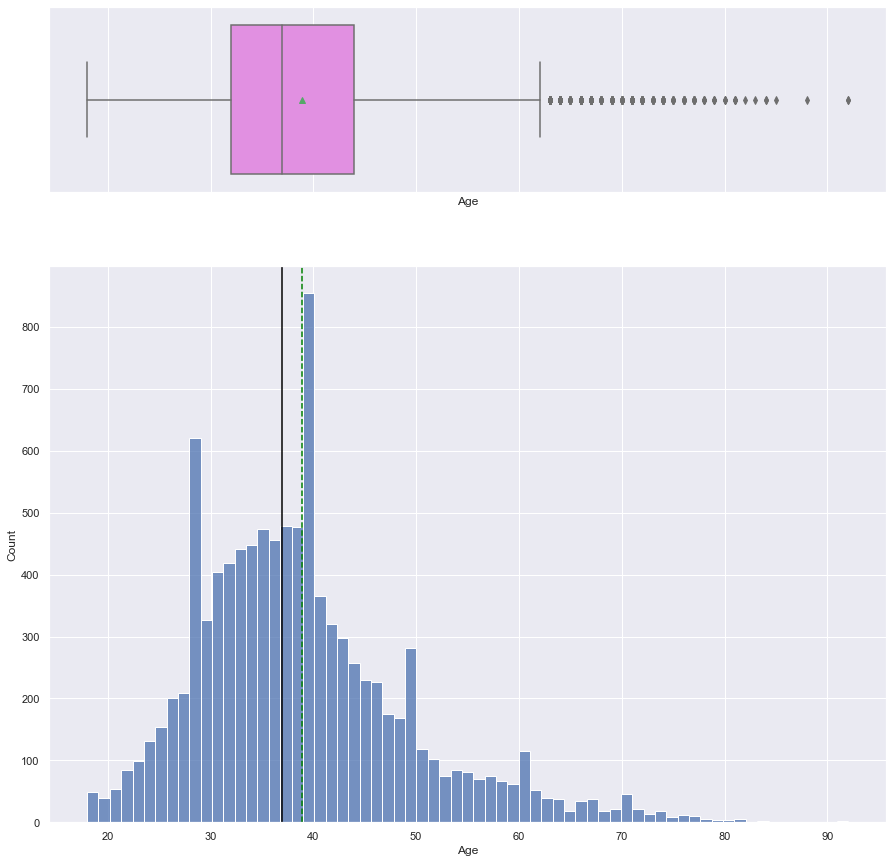

In [116]:
histogram_boxplot(bank['Age'])

`Age` distribution is skewed to the right with many outlier and a few extreme outliers

In [117]:
bank['Age'][bank['Age'] >= 70].value_counts(sort=False)

70    18
71    27
72    21
73    13
74    18
75     9
76    11
77    10
78     5
79     4
80     3
81     4
82     1
83     1
84     2
85     1
88     1
92     2
Name: Age, dtype: int64

We will drop rows with age > 77 (24 rows < 1%).

Not shown: dropping `Age` outliers improves models performance.

In [118]:
bank.drop(index=bank[bank['Age'] > 77].index,inplace=True)
bank['Age'][bank['Age'] >= 70].value_counts(sort=False)

70    18
71    27
72    21
73    13
74    18
75     9
76    11
77    10
Name: Age, dtype: int64

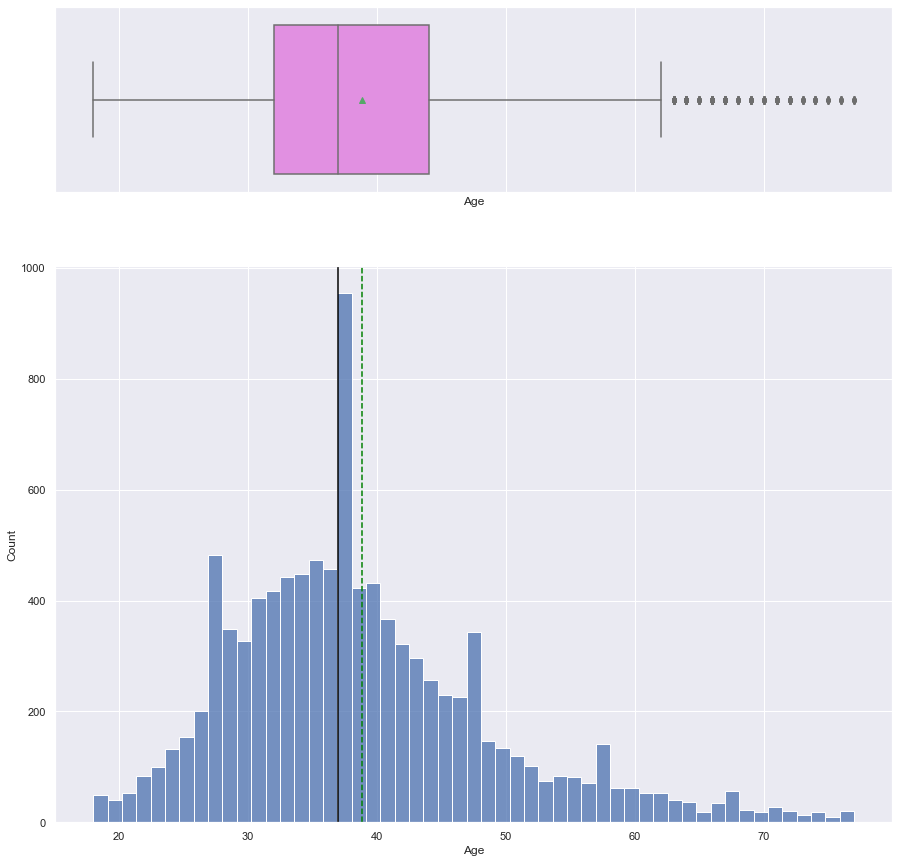

In [119]:
histogram_boxplot(bank['Age'])

Distribution is still skewed to the right.

##### CreditScore

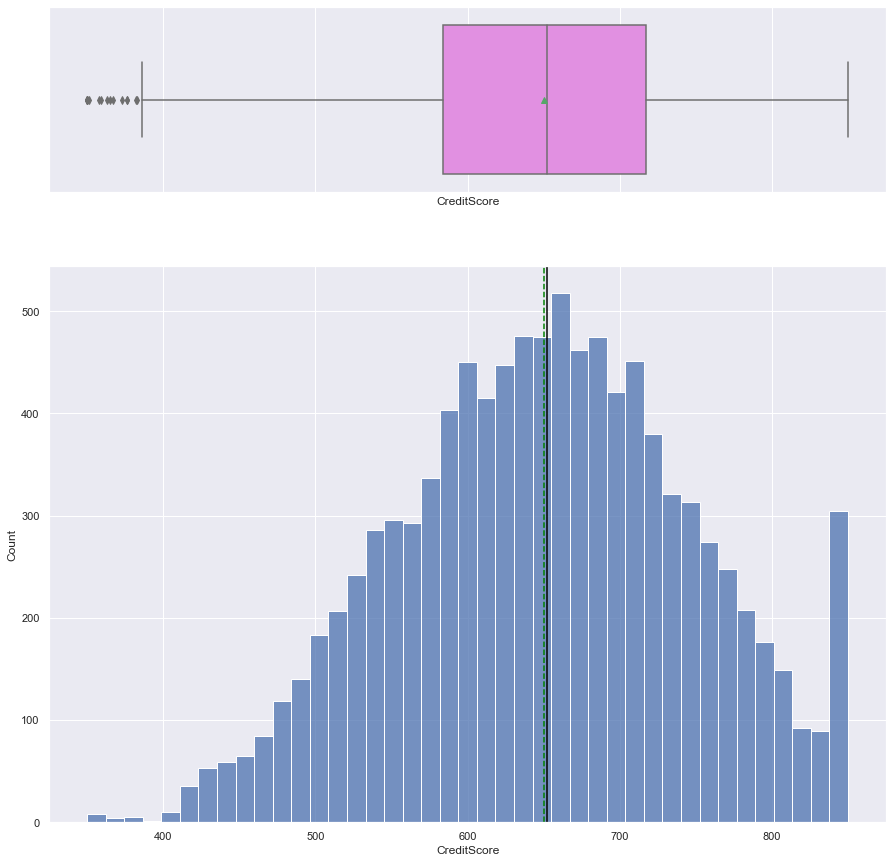

In [120]:
histogram_boxplot(bank['CreditScore'])

`CreditScore` is almost normally distributed with a number of outliers to the left (< ~ 400) and a peak at 850 which is probably the maximum credit score.

##### Tenure

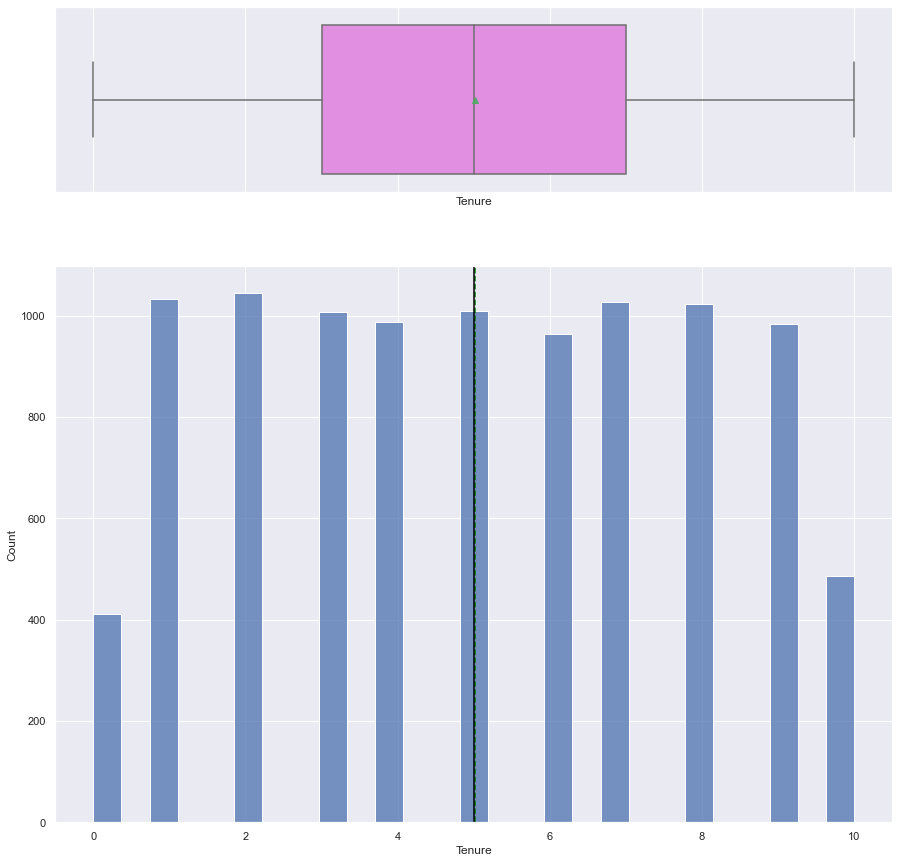

In [121]:
histogram_boxplot(bank['Tenure'])

`Tenure` is almost uniformly distributed except for the extremes of the range (0 and 10) which are tapering off.

##### EstimatedSalary

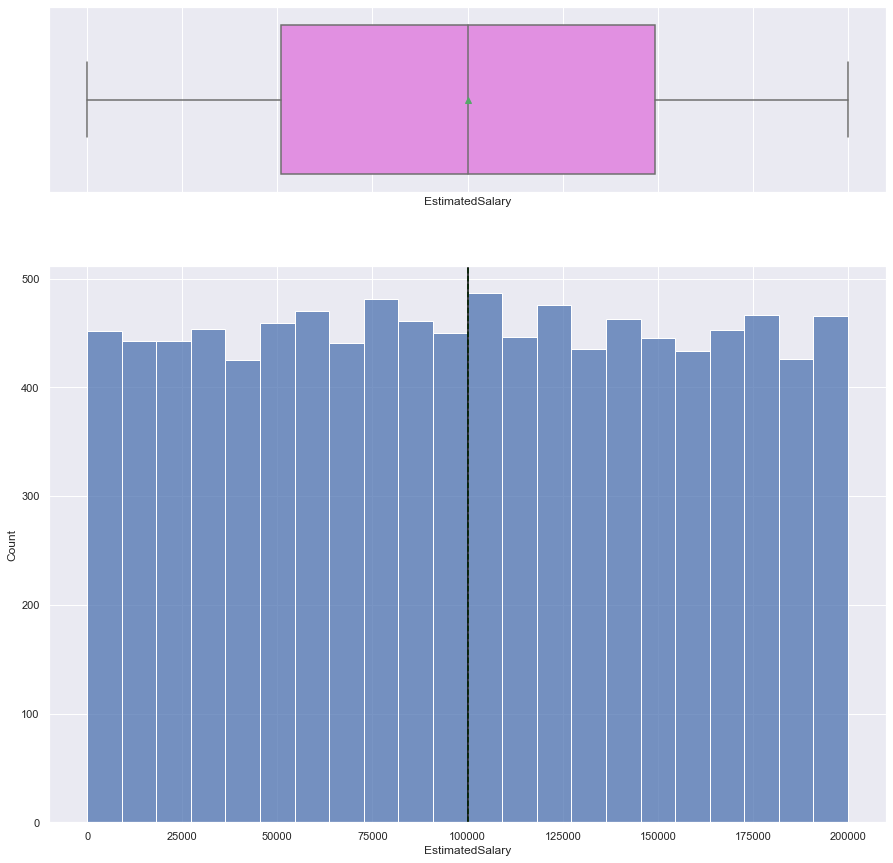

In [122]:
histogram_boxplot(bank['EstimatedSalary'])

`EstimatedSalary` is uniformly distributed.

##### NumOfProducts

In [123]:
bank['NumOfProducts'].value_counts()

1    5072
2    4578
3     266
4      60
Name: NumOfProducts, dtype: int64

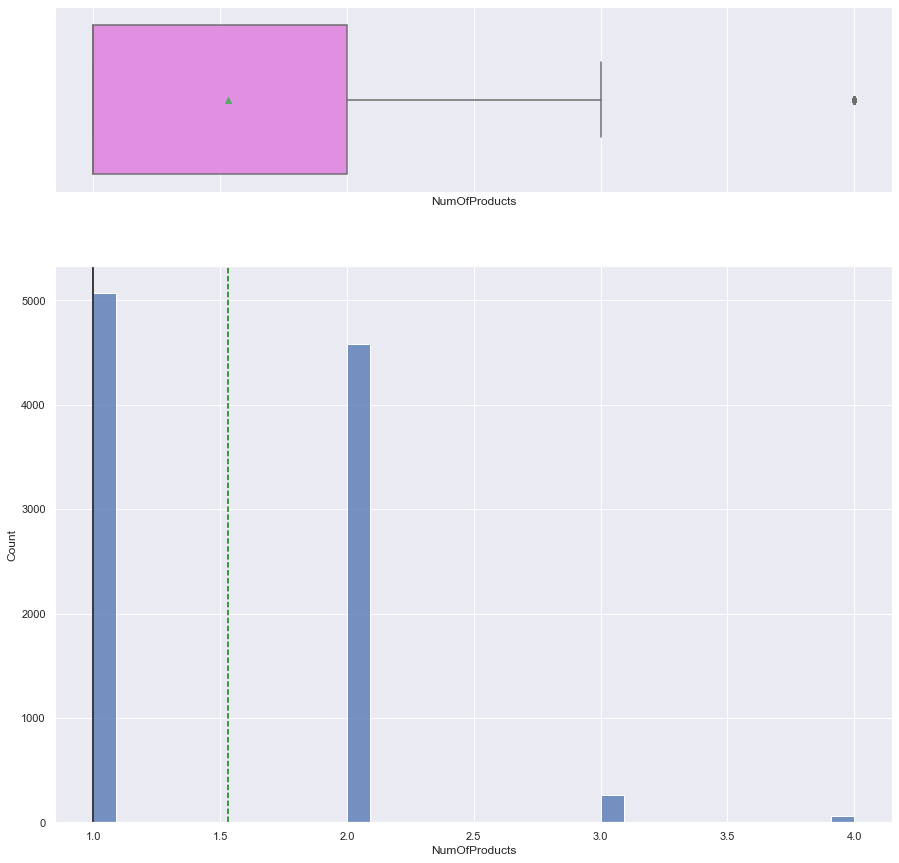

In [124]:
histogram_boxplot(bank['NumOfProducts'])

`NumOfProducts` is discrete and skewed to the right.  Most customers have either 1 or 2 products.

We will drop the outliers with more than 3 products (60 records < 1%).

Not shown: dropping outliers for `NumOfProducts` improves models performance.

In [125]:
# drop outliers
bank.drop(index=bank[bank['NumOfProducts'] > 3].index, inplace=True)

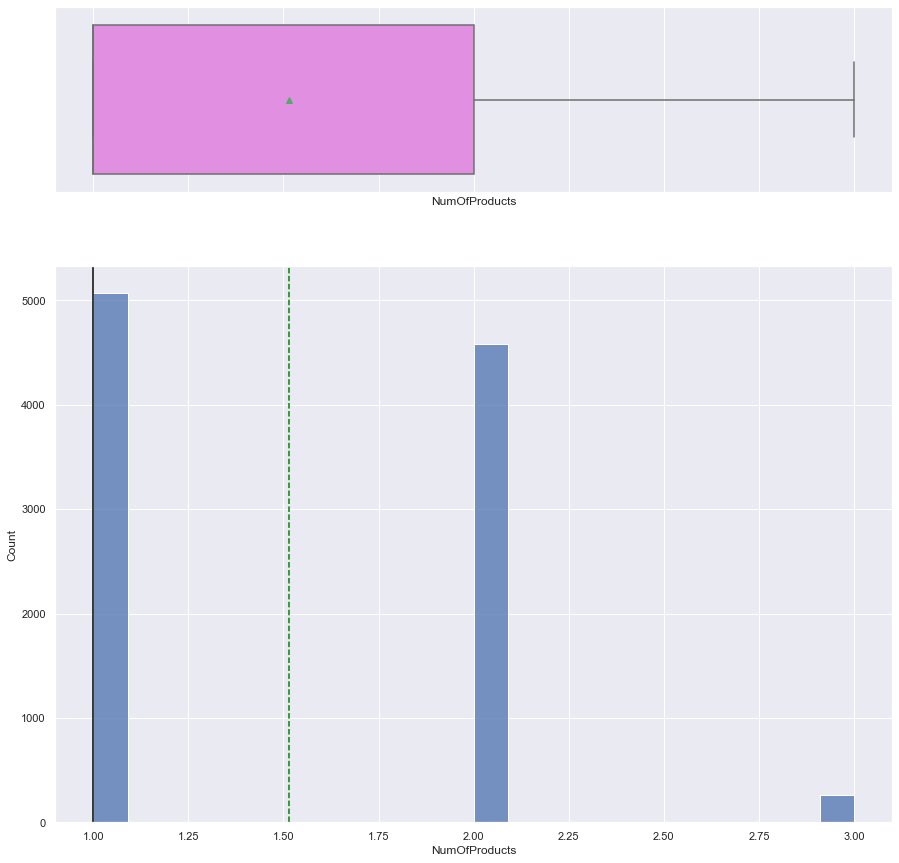

In [126]:
histogram_boxplot(bank['NumOfProducts'])

##### Balance

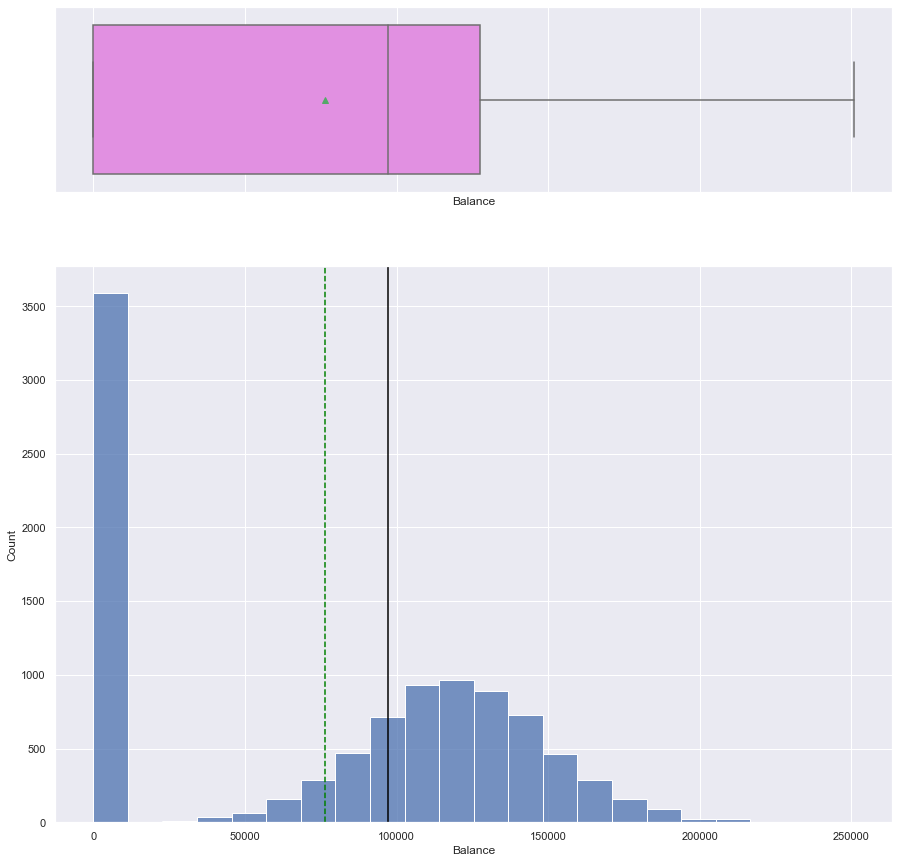

In [127]:
histogram_boxplot(bank['Balance'])

`Balance` is almost normally distributed with the exception of a peak at 0 (36% of customers have zero balance).

Because of the skeweness of the data and the peak at zero, we will break it down into customers with zero balance (0) and customers with a positive balance (1).

Not shown: binning `Balance` improves models performance.

In [128]:
bank['Balance'] = bank['Balance'].apply(lambda x: 0 if x < 1000 else 1)

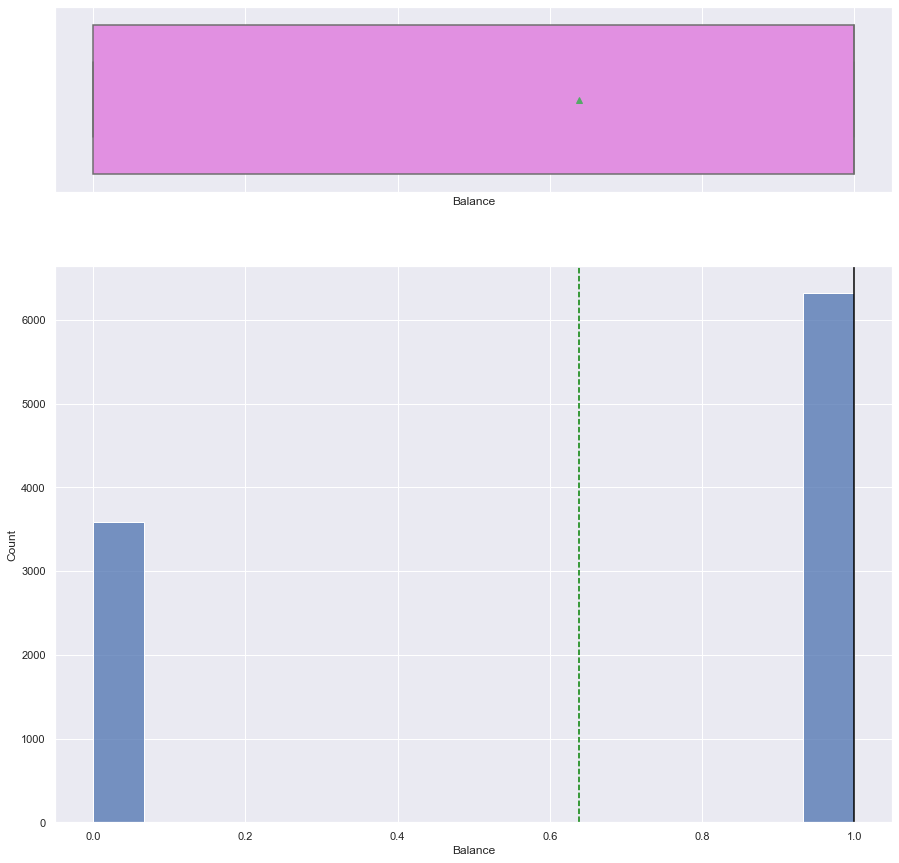

In [129]:
histogram_boxplot(bank['Balance'])

##### Categorical variables univariate analysis

Define function to plot barplot with percentages.

In [130]:
# define function to plot the counts and percentages
def perc_on_bar(z):
    '''
    plot a categorical variable using countplot and add percentages for each value
    z: categorical feature
    the function won't work if a column is passed in hue parameter
    '''

    total = len(z) # length of the column
    plt.figure(figsize=(15,5))
    #plt.xticks(rotation=45)
    ax = sns.countplot(x=z,palette='Paired')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total) # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05 # width of the plot
        y = p.get_y() + p.get_height()           # hieght of the plot
        
        ax.annotate(percentage, (x, y), size = 12) # annotate the percentage 
    plt.show() # show the plot

Note: no additional observations from bar plots for categorical variables in addition to what already covered above. 

##### Geography

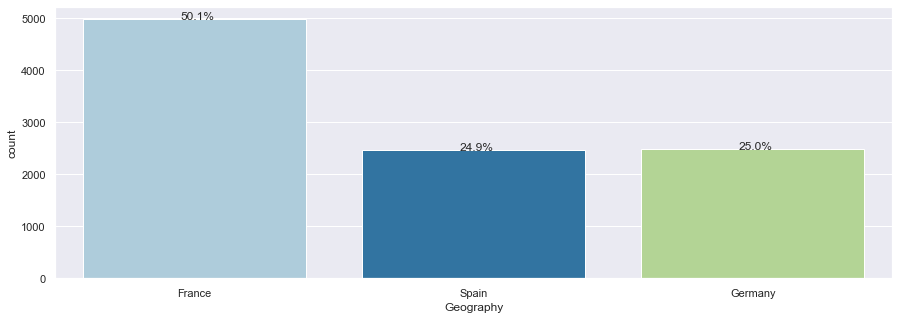

In [131]:
perc_on_bar(bank["Geography"])

##### Gender

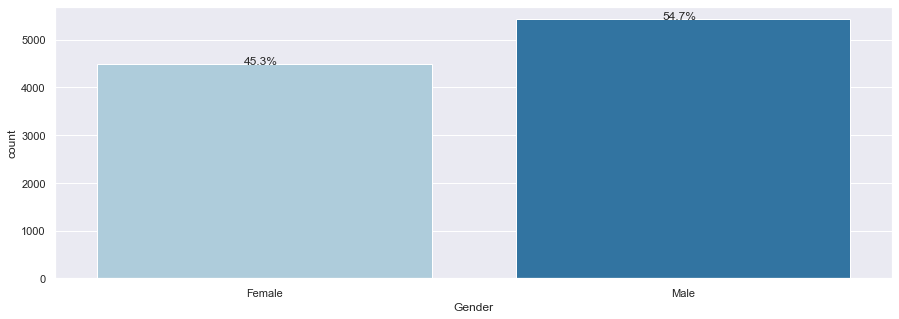

In [132]:
perc_on_bar(bank["Gender"])

##### HasCrCard

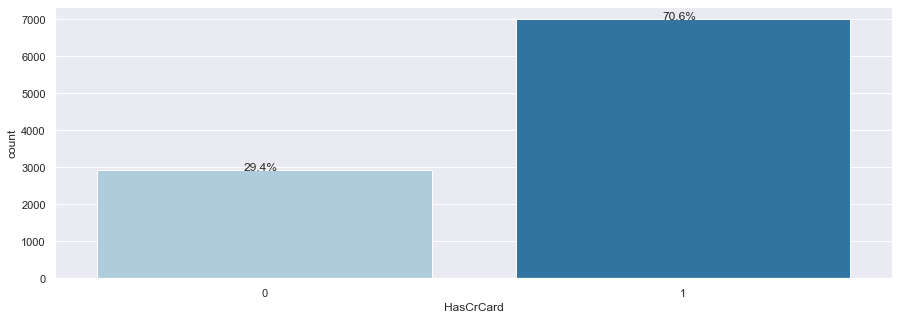

In [133]:
perc_on_bar(bank["HasCrCard"])

##### IsActiveMember

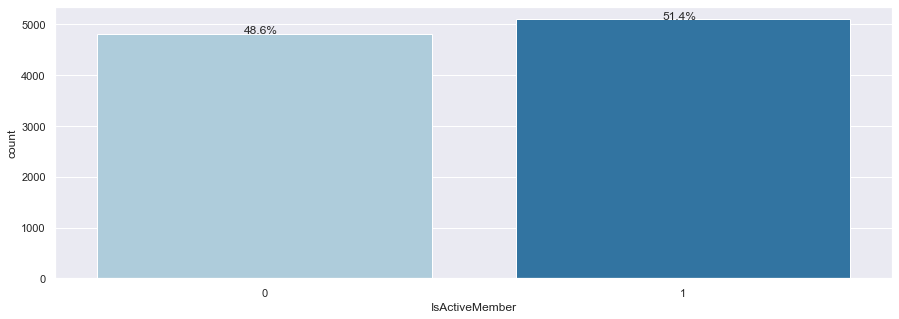

In [134]:
perc_on_bar(bank["IsActiveMember"])

##### Exited

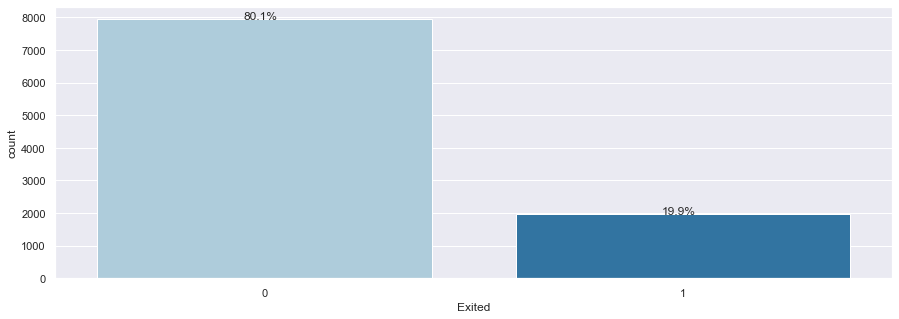

In [135]:
perc_on_bar(bank["Exited"])

## By-Variate Analysis

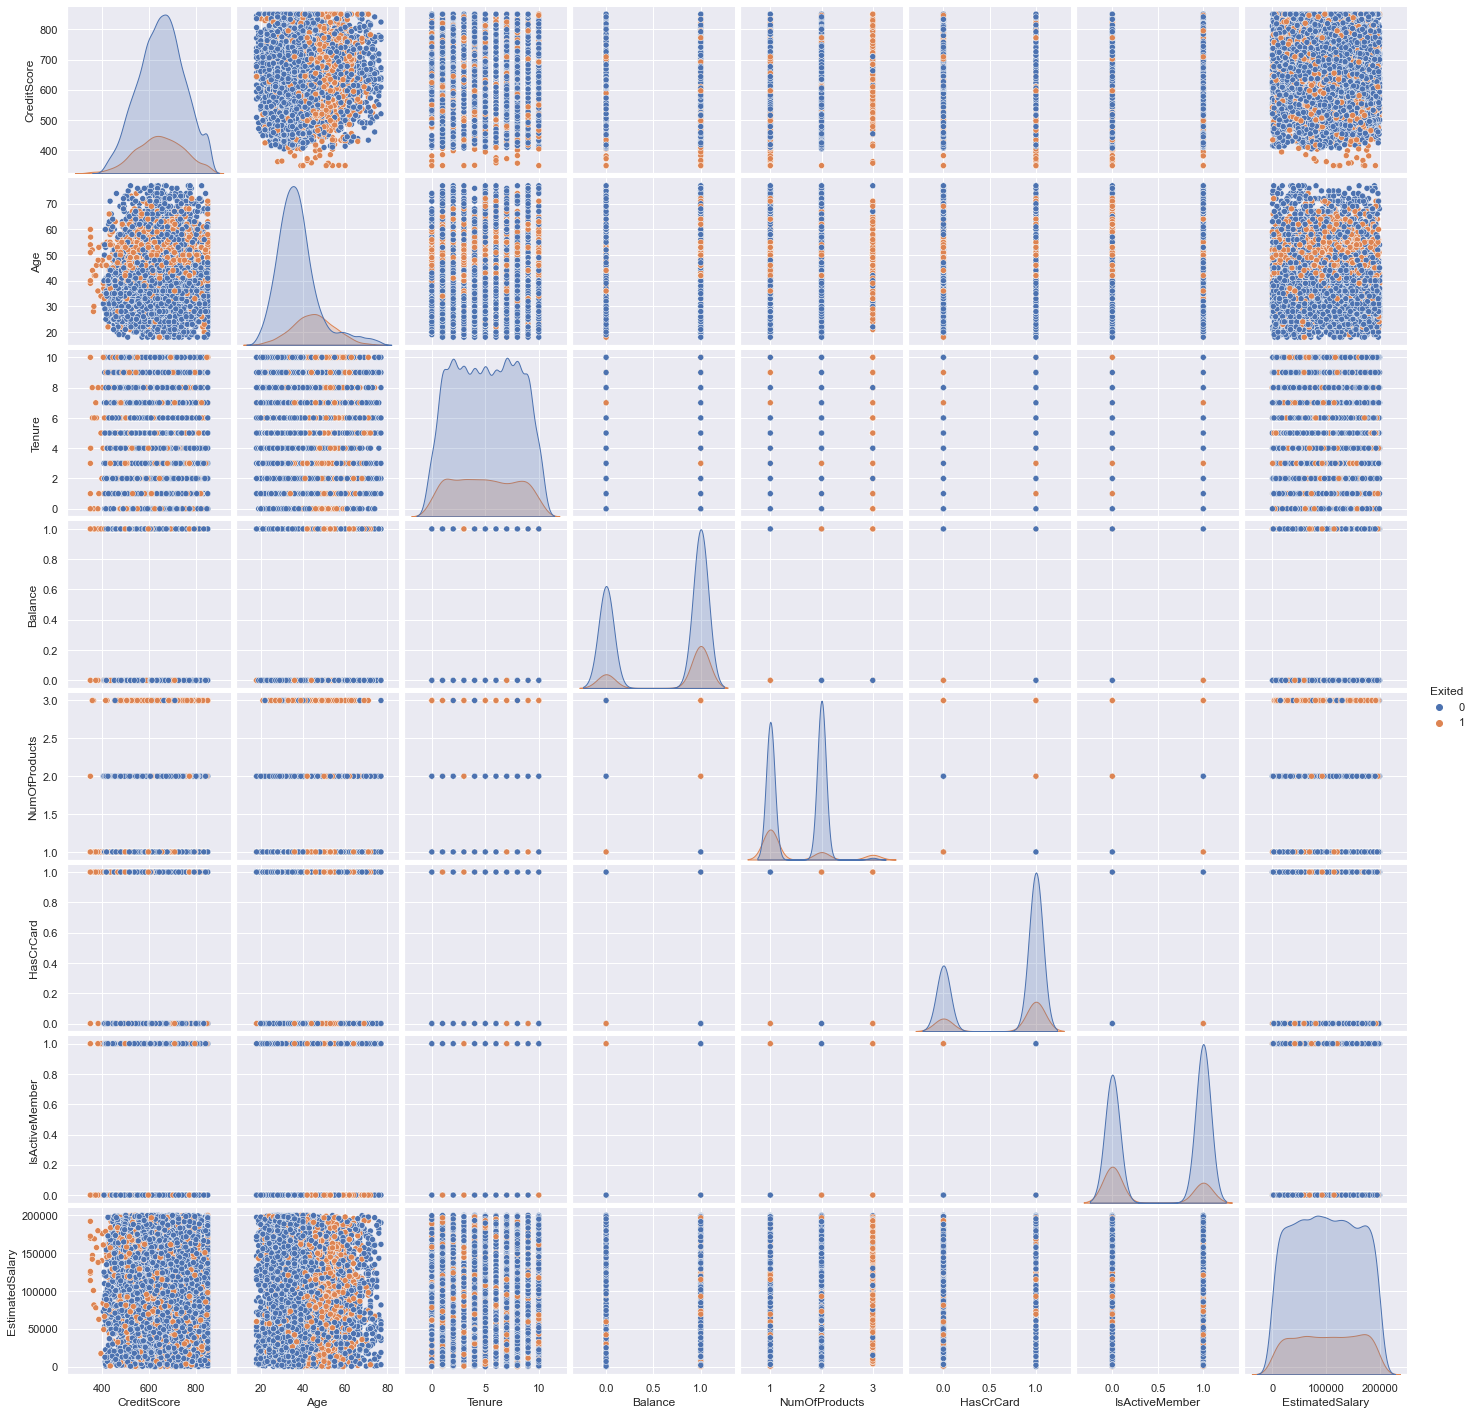

In [136]:
sns.pairplot(bank, hue='Exited')

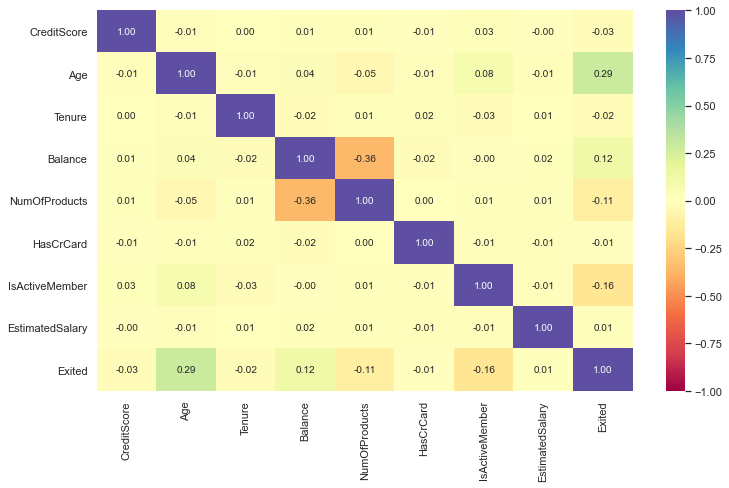

In [137]:
# plot correlation matrix
plt.figure(figsize=(12, 7))
sns.heatmap(
    bank.corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="Spectral"
)
plt.show()

### Pairplots and correlations observations
* `CreditScore` distribution is similar across 'Exited'
* Customers who left the bank tend to have higher `Age`
* `Tenure` doesn't seem to affect whether customers leave or not
* A higher proportion of customer with non-zero `Balance` left the bank as compared to customer with zero `Balance`
* Customers with `NumOfProducts` equal to 1 left the bank at higher rates than those with 2 products
* Customers with a credit card left the bank at higher rates than those with no card.
* Customers who were not active members left the bank at higher rates than those customers who are.
* There is a slight upward trend of customers who left the bank as the `EstimatedSalary` increases

No significant linear correlations found between numeric variables.

##### Age vs Exited

<AxesSubplot:xlabel='Exited', ylabel='Age'>

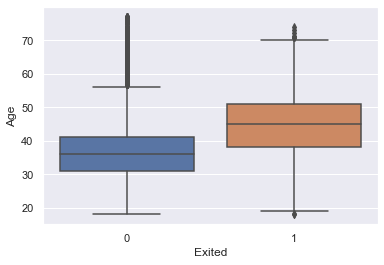

In [138]:
sns.boxplot(y=bank["Age"], x=bank[target_class])

Exited customers tend to have higher age.

##### CreditScore vs Exited

<AxesSubplot:xlabel='Exited', ylabel='CreditScore'>

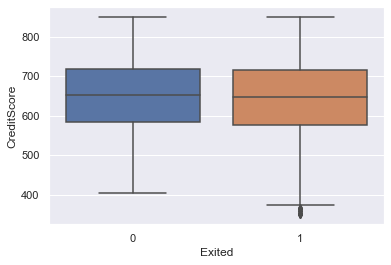

In [139]:
sns.boxplot(y=bank["CreditScore"], x=bank[target_class])

There are more customers near the low end of Credit score who Exited.

##### Tenure vs Exited

<AxesSubplot:xlabel='Exited', ylabel='Tenure'>

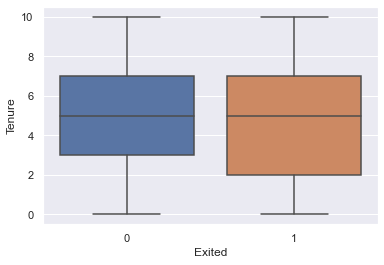

In [140]:
sns.boxplot(y=bank["Tenure"], x=bank[target_class])

Exited customers have a larger IQR than non-exited customers.  Median and range are the same across customers.

##### EstimatedSalary vs Exited

<AxesSubplot:xlabel='Exited', ylabel='EstimatedSalary'>

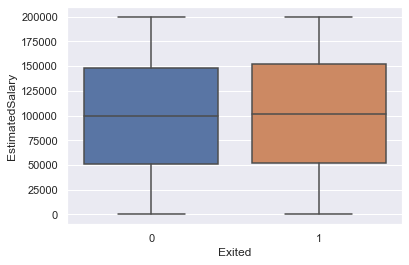

In [141]:
sns.boxplot(y=bank["EstimatedSalary"], x=bank[target_class])

There are no apparent differences in the EstimatedSalary distributions between exited and non-exited customers.

##### NumOfProducts vs Exited

<AxesSubplot:xlabel='Exited', ylabel='NumOfProducts'>

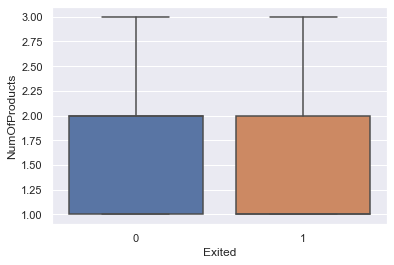

In [142]:
sns.boxplot(y=bank["NumOfProducts"], x=bank[target_class])

There are no apparent differences in this plot of NumOfProducts distributions between exited and non-exited customers.

##### Balance vs Exited

<AxesSubplot:xlabel='Exited', ylabel='Balance'>

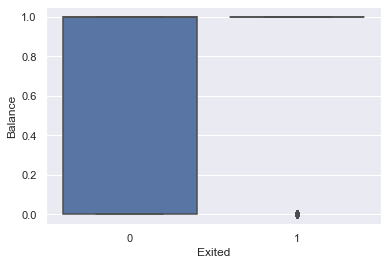

In [143]:
sns.boxplot(y=bank["Balance"], x=bank[target_class])

Exited customers tend to have slightly higher Balance than non-exited

#### Bi-variate analysis for categorical variables

In [144]:
### Function to plot stacked bar charts for categorical columns
def stacked_plot(data, x, y):
    ''' Plot stacked bar charts.
        data = dataframe,
        x = categorical column to plot across x axis
        y = categorical column to stack
    '''
    sns.set()
    ## crosstab 
    tab1 = pd.crosstab(data[x],data[y],margins=True)
    print(tab1)
    print('-'*120)
    ## visualising the cross tab
    tab = pd.crosstab(data[x],data[y],normalize='index')
    tab.plot(kind='bar',stacked=True,figsize=(17,7))
    plt.legend(loc='lower left', frameon=False,)
    plt.legend(loc="upper left", bbox_to_anchor=(1,1))
    plt.show()

##### Geography vs Exited

Exited        0     1   All
Geography                  
France     4190   780  4970
Germany    1691   790  2481
Spain      2059   406  2465
All        7940  1976  9916
------------------------------------------------------------------------------------------------------------------------


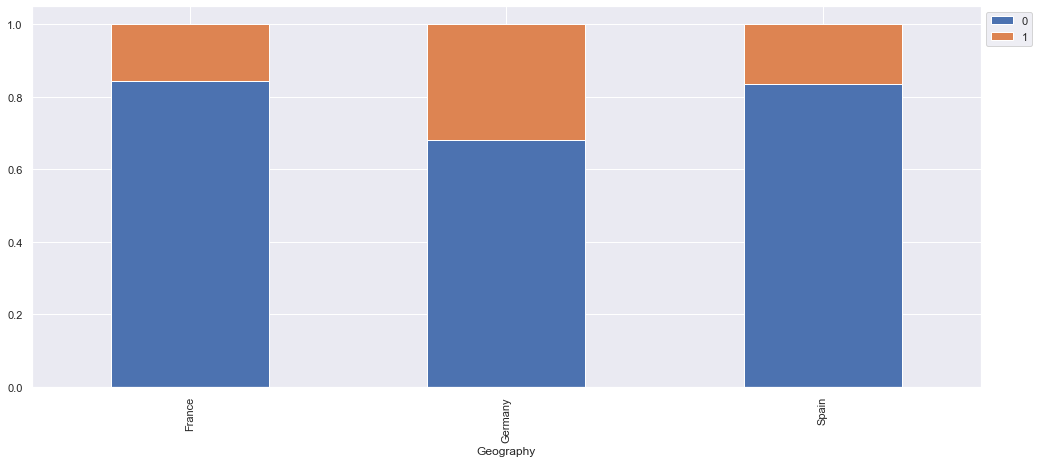

In [145]:
stacked_plot(bank, "Geography", target_class)

Customers from Germany leave at higher rates than other countries.

##### Gender vs Exited

Exited     0     1   All
Gender                  
Female  3393  1100  4493
Male    4547   876  5423
All     7940  1976  9916
------------------------------------------------------------------------------------------------------------------------


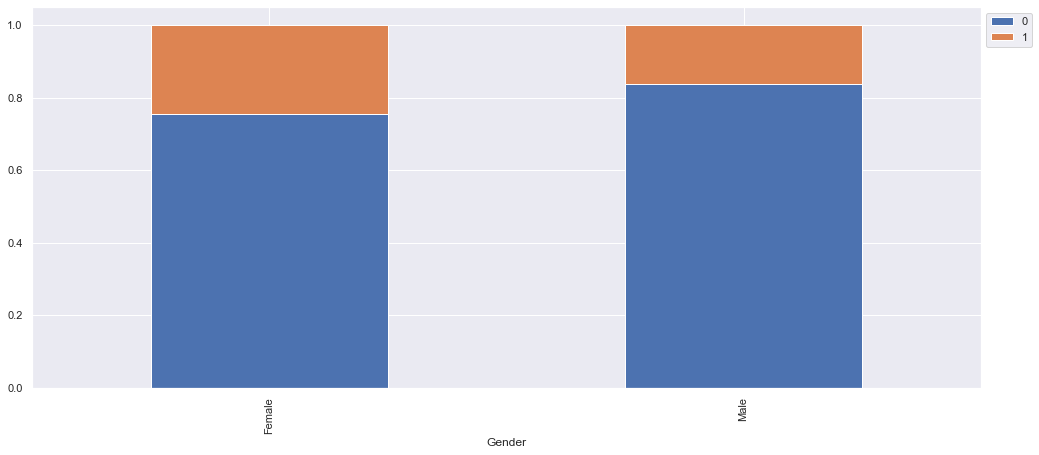

In [146]:
stacked_plot(bank, "Gender", target_class)

Females leave at higher rates than Males.

##### HasCrCard vs Exited

Exited        0     1   All
HasCrCard                  
0          2325   593  2918
1          5615  1383  6998
All        7940  1976  9916
------------------------------------------------------------------------------------------------------------------------


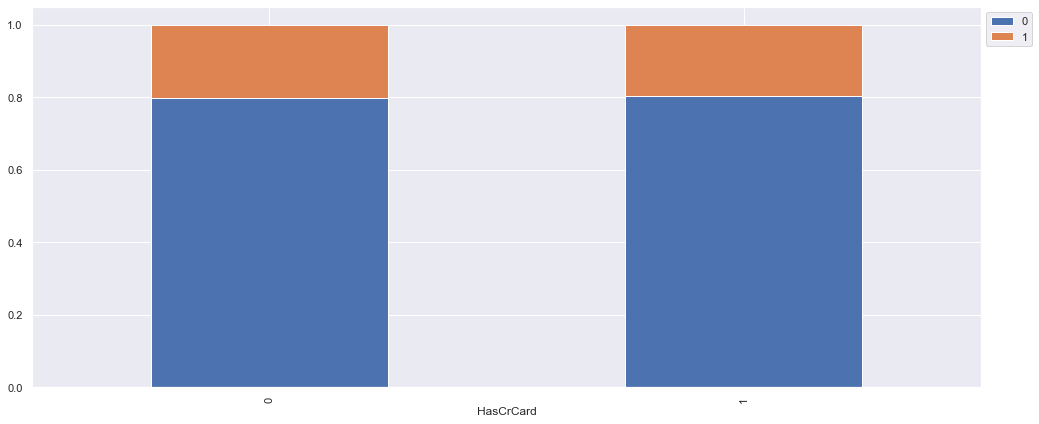

In [147]:
stacked_plot(bank, "HasCrCard", target_class)

There is only a slight difference in rates of Exited between customers with or without a credit card.

##### IsActiveMember vs Exited

Exited             0     1   All
IsActiveMember                  
0               3547  1270  4817
1               4393   706  5099
All             7940  1976  9916
------------------------------------------------------------------------------------------------------------------------


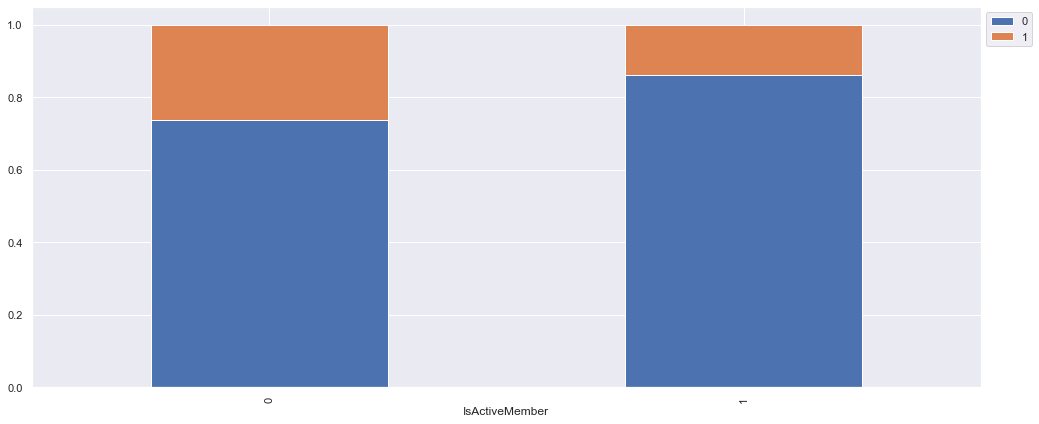

In [148]:
stacked_plot(bank, "IsActiveMember", target_class)

Inactive members leave the bank at higher rates than active ones.

### Data preparation prior to modeling

Split data into train , validation and test sets

In [149]:
from sklearn.model_selection import train_test_split

# Split target from features
X = bank.drop(target_class, axis=1)

# encode categorical variable
#X = pd.get_dummies(X)
X = pd.get_dummies(X, drop_first=True)

y = bank[target_class]
# split out test
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X_intermediate, y_intermediate, test_size=0.25, random_state=1, stratify=y_intermediate)

print(X_train.shape, X_val.shape, X_test.shape)
print(f'Target train class ratio: {100*(y_train[y_train == 1]).count()/len(y_train)}')
print(f'Target val class ratio: {100*(y_val[y_val == 1]).count()/len(y_val)}')
print(f'Target test class ratio: {100*(y_test[y_test == 1]).count()/len(y_test)}')

(5949, 11) (1983, 11) (1984, 11)
Target train class ratio: 19.93612371827198
Target val class ratio: 19.919314170448814
Target test class ratio: 19.909274193548388


In [150]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9916 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9916 non-null   int64  
 1   Age                9916 non-null   int64  
 2   Tenure             9916 non-null   int64  
 3   Balance            9916 non-null   int64  
 4   NumOfProducts      9916 non-null   int64  
 5   HasCrCard          9916 non-null   int64  
 6   IsActiveMember     9916 non-null   int64  
 7   EstimatedSalary    9916 non-null   float64
 8   Geography_Germany  9916 non-null   uint8  
 9   Geography_Spain    9916 non-null   uint8  
 10  Gender_Male        9916 non-null   uint8  
dtypes: float64(1), int64(7), uint8(3)
memory usage: 1.0 MB


##### Scale features

In [151]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = MinMaxScaler() 
# models have lower performance if minmax scaler is used

scaler = StandardScaler()

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [152]:
print(np.mean(X_train, axis=0))
print(np.mean(X_val, axis=0))
print(np.mean(X_test, axis=0))

[ 2.57988285e-16  7.10662175e-17  1.67214629e-17  1.73186580e-17
 -1.38549264e-16 -2.38878042e-17  7.50972844e-17  2.01254750e-16
  3.94148769e-17  1.19439021e-17  6.21082909e-17]
[ 0.02829322 -0.02146811 -0.00994309 -0.05066641  0.04213599  0.00884623
 -0.0094163  -0.01358811  0.01631263 -0.00194637 -0.03954623]
[ 0.00823342  0.02703946 -0.01467768 -0.05026898  0.04439829 -0.00077917
  0.02637334  0.01151363 -0.00960751  0.00943755 -0.00866709]


### Model training and evaluation

#### Model evaluation criteria
When classifying we have False Positive and False Negative errors.
* False Positive = we predict a customer will leave but the customer doesn't.  
    This might result in effort wasted on retaining customers who were not planning on leaving.
* False Negative = we predict a customer will not leave but the customer does.  
    This is a lost opportunity to retain a customer with corresponding revenue loss.
    
For this classification we want to reduce the number of false negatives.

We will use AUC score to evaluate the model overall and also consider Recall.

##### Sanity check with traditional ML algorithm

###### Function to plot confusion matrix

In [153]:
def plot_confusion_matrix(model, X, y_actual, threshold=0.5):
    '''Plot confusion matrix from model, X and y_actual.
    '''
    if hasattr(model, 'predict_proba') and callable(getattr(model, 'predict_proba')):
        y_predict = (model.predict_proba(X)[:,1] > threshold) * 1
    else:
        y_predict = (model.predict(X) > threshold) * 1
        
    cm = metrics.confusion_matrix(y_actual, y_predict)
    # print(cm.flatten())
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]
    TP = cm[1,1]
    # print(f'TN:{TN}, FN:{FN}, TP:{TP}, FP:{FP}')
    accuracy  = (TP + TN) / (TN+FN+TP+FP) 
    precision = TP / (TP + FP)
    recall    = TP / (TP + FN)
    f1_score  = 2 * precision * recall / (precision + recall)
    scores = "\nAccuracy={:0.3f} - Precision={:0.3f} - Recall={:0.3f} - F1 Score={:0.3f}".format(accuracy,precision,recall,f1_score)
    df_cm = pd.DataFrame(cm, index = [i for i in ["0","1"]],
                  columns = [i for i in ["Predict 0","Predict 1"]])
    group_names = ['TN', 'FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                     cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(5,3))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='Spectral')
    print(scores)
    return accuracy, precision, recall, f1_score

###### Function to plot ROC-AUC curves

In [154]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve

def plot_roc_auc(classifier, x, y):
    if hasattr(classifier, 'predict_proba') and callable(getattr(classifier, 'predict_proba')):
        predict_prob = classifier.predict_proba(x)[:,1]
    else:
        predict_prob = classifier.predict(x)
                                                 
    zero_predict = np.zeros(y.shape[0])
    # get auc score
    ns_auc = roc_auc_score(y, zero_predict)
    nn_auc = roc_auc_score(y, predict_prob)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (nn_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y, zero_predict)
    nn_fpr, nn_tpr, _ = roc_curve(y, predict_prob)
    # plot the roc curve for the model
    plt.figure(figsize=(6,6))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(nn_fpr, nn_tpr, marker='.', label='NN')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    
    # precision/recall curve
    prec, rec, thr = metrics.precision_recall_curve(y, predict_prob)

    # find optimal threshold : min of difference between rec and prec
    pr_diff = np.abs(rec-prec)
    optimal_threshold = thr[np.argmin(pr_diff)]
    # get recall score using the optimal threshold
    predict_optimal_threshold = (predict_prob > optimal_threshold ) * 1
    recall_for_optimal_threshold = metrics.recall_score(y, predict_optimal_threshold)

    # Plot threshold vs Precision/Recall
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(thr, prec[:-1], 'b--', label='precision')
    ax.plot(thr, rec[:-1], 'g--', label = 'recall')
    plt.xlabel('Threshold')
    plt.legend(loc='lower left')
    plt.ylim([0,1])
    ax.set_xticks(np.arange(0,1.05,0.05))
    ax.grid(markevery=10, which='major')
    plt.show()
    
    return nn_auc, optimal_threshold, recall_for_optimal_threshold

In [155]:
def plot_model_metrics(modl, x, y):
    modl.evaluate(x, y)
    accuracy, precision, recall, f1_score = plot_confusion_matrix(modl, x, y)
    plt.show()
    auc_score, optimal_threshold, recall_opt_thr = plot_roc_auc(modl, x, y)
    return auc_score, accuracy, precision, recall, f1_score, optimal_threshold, recall_opt_thr

In [156]:
from xgboost import XGBClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score

models = [] # holds models to be trained
model_names = []
cv_scores = []  # holds cross-validation score for each model
val_scores = []  # validation set score

# models.append(('Decision Tree', DecisionTreeClassifier(random_state=1)))
# models.append(('Random Forest', RandomForestClassifier(random_state=1)))
# models.append(('Adaboost', AdaBoostClassifier(random_state=1)))
# models.append(('Gradient Boost', GradientBoostingClassifier(random_state=1)))
# models.append(('Logistic Reg', LogisticRegression(random_state=1)))
models.append(('XGBoost', XGBClassifier(random_state=1, eval_metric='logloss', use_label_encoder=False)))

# Use recall to evaluate model metrics
scorer = metrics.make_scorer(metrics.recall_score)
splits = 5  # cross-validation folds

kfold = StratifiedKFold(n_splits=splits, random_state=1, shuffle=True)

def run_ml_models(x,y,xval,yval):
    model_names = []
    cv_scores = []  # holds cross-validation score for each model
    val_scores = []  # validation set score
    
    for name, clf in models:
        model_names.append(name)
        print('Model name:', name,'\n===========')
        score = cross_val_score(estimator=clf, X=x, y=y, scoring=scorer, cv=kfold)
        cv_scores.append(score)
        print('> Avg. Score:(train)',round(np.mean(score),5), 'CV scores:',score,)
        clf.fit(x, y)

        val_score = metrics.recall_score(yval, clf.predict(xval))
        val_scores.append(val_score)
        print('> Validation recall:', round(val_score,5))

        print('\nConfusion matrix: train set')
        plot_confusion_matrix(clf, x, y)
        plt.show()
        print('\nConfusion matrix: validation set')
        plot_confusion_matrix(clf, xval, yval)
        plt.show()
        
        plot_roc_auc(clf, xval, yval)

Model name: XGBoost 
> Avg. Score:(train) 0.44097 CV scores: [0.40506329 0.4556962  0.43037975 0.44537815 0.46835443]
> Validation recall: 0.46076

Confusion matrix: train set

Accuracy=0.955 - Precision=0.971 - Recall=0.799 - F1 Score=0.877


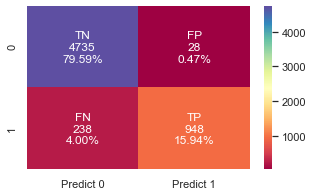


Confusion matrix: validation set

Accuracy=0.857 - Precision=0.719 - Recall=0.461 - F1 Score=0.562


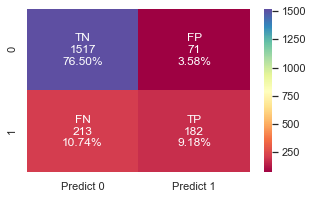

No Skill: ROC AUC=0.500
Model: ROC AUC=0.848


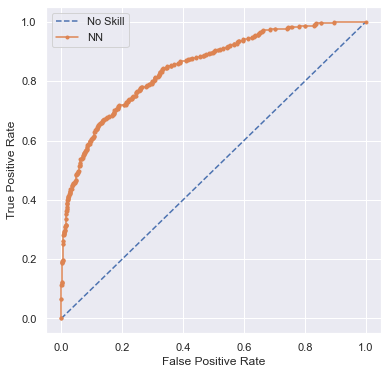

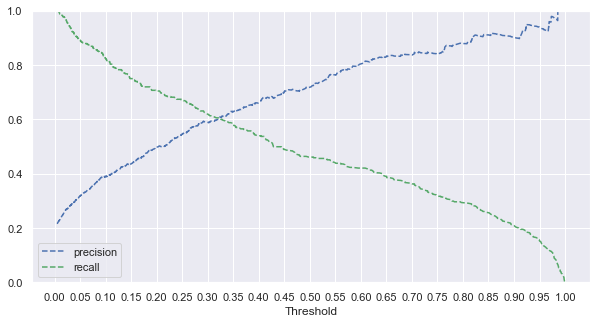

Wall time: 3.89 s


In [157]:
%%time
run_ml_models(X_train,y_train,X_val,y_val)

Performance of the model is low with recall less than 50% against validation sets.

Also the model is overfit (more than 30% difference between train and validation scores) 

##### Model using Neural Network

In [158]:
# function to create model based on parameter 'layers'
def create_model(layers):
    # neural network
    model = Sequential()

    for layer in layers:
        model.add(layer)

    # metric
    recall_metric = tf.keras.metrics.Recall()

    # compile the model
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[recall_metric]
                 )
    return model

In [159]:
# define the layers to be used by the mode
# first hidden layer with n units and second hidden layer with 2n+1
model_layers_13_27 = [
    Dense(13, activation='relu'),
    Dense(27, activation='relu'),
    Dense(1, activation=tf.keras.activations.sigmoid)
]

model = create_model(model_layers_13_27)

In [160]:
%%time
# fit the model
history = model.fit(X_train, y_train, epochs=20,validation_split=0.2)

Epoch 1/20
149/149 [==============================] - 1s 2ms/step - loss: 0.5171 - recall_8: 0.0331 - val_loss: 0.4794 - val_recall_8: 0.0000e+00
Epoch 2/20
149/149 [==============================] - 0s 1ms/step - loss: 0.4387 - recall_8: 0.0160 - val_loss: 0.4560 - val_recall_8: 0.0520
Epoch 3/20
149/149 [==============================] - 0s 1ms/step - loss: 0.4169 - recall_8: 0.1592 - val_loss: 0.4455 - val_recall_8: 0.1960
Epoch 4/20
149/149 [==============================] - 0s 1ms/step - loss: 0.4056 - recall_8: 0.2350 - val_loss: 0.4417 - val_recall_8: 0.2720
Epoch 5/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3981 - recall_8: 0.2756 - val_loss: 0.4369 - val_recall_8: 0.2240
Epoch 6/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3913 - recall_8: 0.2853 - val_loss: 0.4314 - val_recall_8: 0.2680
Epoch 7/20
149/149 [==============================] - 0s 2ms/step - loss: 0.3837 - recall_8: 0.3269 - val_loss: 0.4269 - val_recall_8: 0.2840
Ep

62/62 [==============================] - 0s 885us/step - loss: 0.3217 - recall_8: 0.4911

Accuracy=0.858 - Precision=0.705 - Recall=0.491 - F1 Score=0.579


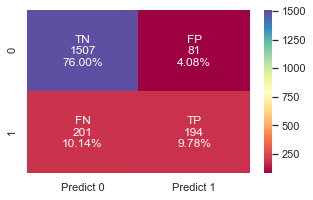

No Skill: ROC AUC=0.500
Model: ROC AUC=0.882


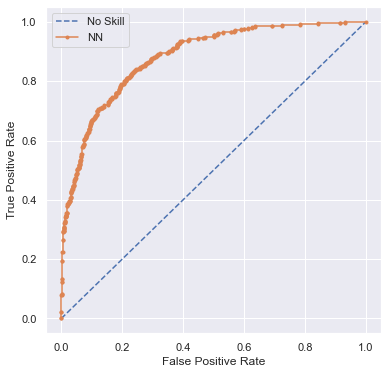

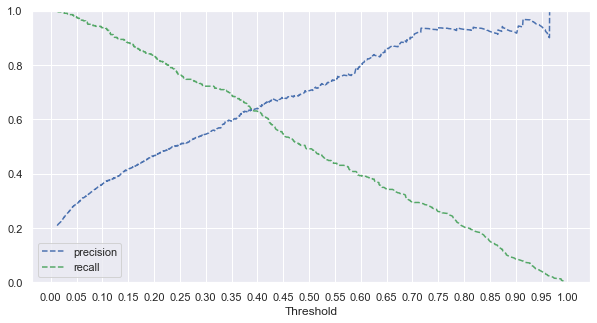

In [161]:
#plot metrics
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model,X_val,y_val)

In [162]:
scores_columns = ['Model','AUC','Accuracy','Precision','Recall','f1-score',
                 'Optimal Threshold', 'Recall at opt thr']
scores = pd.DataFrame([['13/27 Two layers NN', auc, acc, prec, rec, f1, thr, rec_thr]],
                      columns=scores_columns)
scores

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633


Model performance with the inital NN and using default threshold is low with large number of False Negatives.

Using a threshold of 0.341 raises the recall to 0.628.

In [163]:
def plot_loss_by_epoch(history):
    # Capturing learning history per epoch
    hist  = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Plotting accuracy at different epochs
    plt.plot(hist['loss'])
    plt.plot(hist['val_loss'])
    plt.legend(("train" , "valid") , loc =0)
    plt.show()

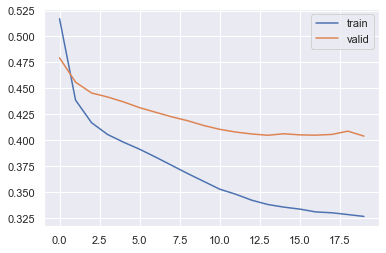

In [164]:
plot_loss_by_epoch(history)

We will try different NN hyperparameter to see if we can get better performance.

As the target class is imbalanced, we will also train with undersampled and upsampled data to see if we can improve performance.

In [165]:
# current counts of target label
print("Before UpSampling, counts of Exited = 1: {}".format(sum(y_train == 1)))
print("Before UpSampling, counts of Exited = 0: {} \n".format(sum(y_train == 0)))

Before UpSampling, counts of Exited = 1: 1186
Before UpSampling, counts of Exited = 0: 4763 



In [166]:
# Use SMOTE to oversample
sm_oversampler = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_oversmpl, y_train_oversmpl = sm_oversampler.fit_resample(X_train, y_train)

# post oversample counts of target label
print("After UpSampling, counts of Exited = 1: {}".format(sum(y_train_oversmpl == 1)))
print("After UpSampling, counts of Exited = 0: {} \n".format(sum(y_train_oversmpl == 0)))
print(f"Shape of oversample dataframes: X: {X_train_oversmpl.shape}, y: {y_train_oversmpl.shape}")

After UpSampling, counts of Exited = 1: 4763
After UpSampling, counts of Exited = 0: 4763 

Shape of oversample dataframes: X: (9526, 11), y: (9526,)


Model name: XGBoost 
> Avg. Score:(train) 0.87508 CV scores: [0.88037775 0.8697479  0.875      0.86358867 0.88667366]
> Validation recall: 0.53671

Confusion matrix: train set

Accuracy=0.963 - Precision=0.986 - Recall=0.940 - F1 Score=0.962


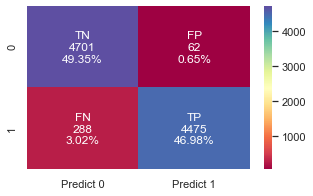


Confusion matrix: validation set

Accuracy=0.861 - Precision=0.697 - Recall=0.537 - F1 Score=0.607


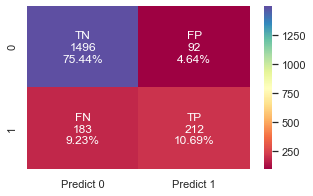

No Skill: ROC AUC=0.500
Model: ROC AUC=0.857


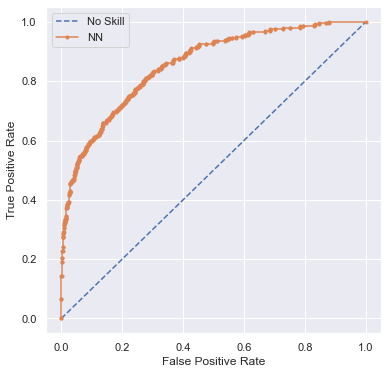

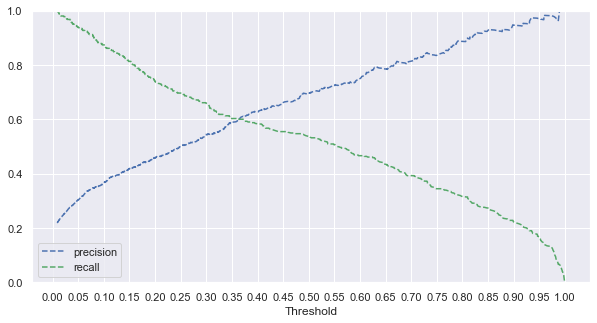

In [167]:
run_ml_models(X_train_oversmpl,y_train_oversmpl,X_val,y_val)

Performance of XGBoost is higher when training on oversampled data with Recall = 0.534

Use oversampled data to train NN.

In [168]:
model = create_model(model_layers_13_27)
history = model.fit(X_train_oversmpl, y_train_oversmpl, epochs=10,validation_split=0.2)

Epoch 1/10
239/239 [==============================] - 1s 2ms/step - loss: 0.4339 - recall_9: 0.6710 - val_loss: 0.6374 - val_recall_9: 0.6647
Epoch 2/10
239/239 [==============================] - 0s 2ms/step - loss: 0.4292 - recall_9: 0.6790 - val_loss: 0.6370 - val_recall_9: 0.6605
Epoch 3/10
239/239 [==============================] - 0s 2ms/step - loss: 0.4267 - recall_9: 0.6832 - val_loss: 0.6485 - val_recall_9: 0.6432
Epoch 4/10
239/239 [==============================] - 0s 1ms/step - loss: 0.4242 - recall_9: 0.6769 - val_loss: 0.5564 - val_recall_9: 0.7167
Epoch 5/10
239/239 [==============================] - 0s 1ms/step - loss: 0.4217 - recall_9: 0.6881 - val_loss: 0.6453 - val_recall_9: 0.6558
Epoch 6/10
239/239 [==============================] - 0s 1ms/step - loss: 0.4204 - recall_9: 0.6874 - val_loss: 0.6116 - val_recall_9: 0.6689
Epoch 7/10
239/239 [==============================] - 0s 1ms/step - loss: 0.4192 - recall_9: 0.6920 - val_loss: 0.5583 - val_recall_9: 0.7030
Epoch 

62/62 [==============================] - 0s 970us/step - loss: 0.3717 - recall_9: 0.7114

Accuracy=0.825 - Precision=0.546 - Recall=0.711 - F1 Score=0.618


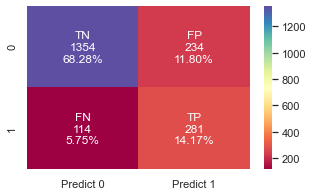

No Skill: ROC AUC=0.500
Model: ROC AUC=0.881


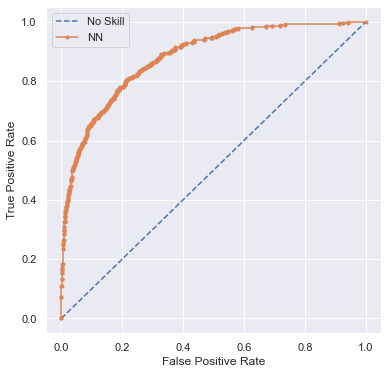

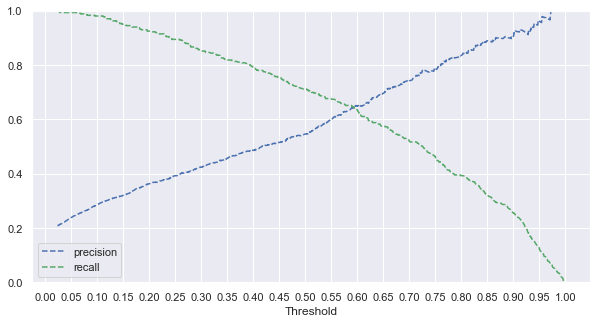

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641


In [169]:
# plot metrics
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model, X_val, y_val)
scores.loc[len(scores.index)] = ['NN 13/27 Oversampled X', auc, acc, prec, rec, f1, thr, rec_thr]
scores

NN trained with oversampled data has higher recall.

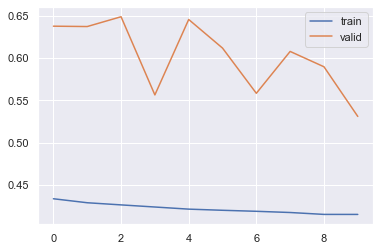

In [170]:
plot_loss_by_epoch(history)

Train models using undersampled data.

In [171]:
# current counts of target label
print("Before undersampling, counts of Exited = 1: {}".format(sum(y_train == 1)))
print("Before undersampling, counts of Exited = 0: {} \n".format(sum(y_train == 0)))

Before undersampling, counts of Exited = 1: 1186
Before undersampling, counts of Exited = 0: 4763 



In [172]:
# get instance of undersampler
undersampler = RandomUnderSampler(sampling_strategy='majority', random_state=1, replacement=False)

# resample the data
X_train_undersmpl, y_train_undersmpl = undersampler.fit_resample(X_train, y_train)

# post oversample counts of target label
print("After undersampling, counts of Exited = 1: {}".format(sum(y_train_undersmpl == 1)))
print("After undersampling, counts of Exited = 0: {} \n".format(sum(y_train_undersmpl == 0)))
print(f"Shape of oversample dataframes: X: {X_train_undersmpl.shape}, y: {y_train_undersmpl.shape}")


After undersampling, counts of Exited = 1: 1186
After undersampling, counts of Exited = 0: 1186 

Shape of oversample dataframes: X: (2372, 11), y: (2372,)


Model name: XGBoost 
> Avg. Score:(train) 0.72006 CV scores: [0.74683544 0.72689076 0.66244726 0.72151899 0.74261603]
> Validation recall: 0.73418

Confusion matrix: train set

Accuracy=0.994 - Precision=0.994 - Recall=0.994 - F1 Score=0.994


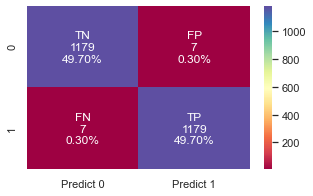


Confusion matrix: validation set

Accuracy=0.753 - Precision=0.430 - Recall=0.734 - F1 Score=0.542


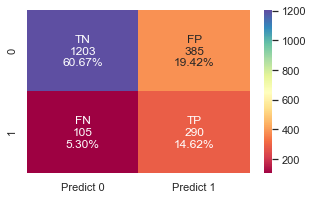

No Skill: ROC AUC=0.500
Model: ROC AUC=0.832


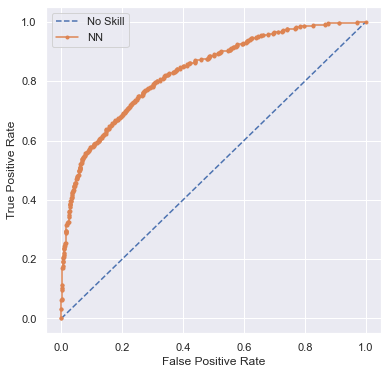

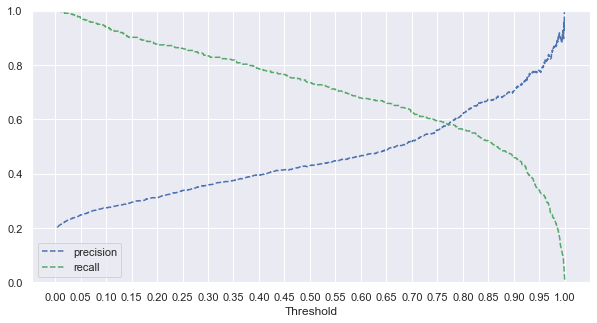

In [173]:
run_ml_models(X_train_undersmpl, y_train_undersmpl, X_val, y_val)

Recall of XGBoost is at 0.733 against validation set but the model is overfit (train recall 0.994 vs validation at 0.733)

Train NN with undersampled data.

In [174]:
model = create_model(model_layers_13_27)
history = model.fit(X_train_undersmpl, y_train_undersmpl, epochs=10,validation_split=0.2)

Epoch 1/10
60/60 [==============================] - 1s 4ms/step - loss: 0.4362 - recall_10: 0.6596 - val_loss: 0.6301 - val_recall_10: 0.6863
Epoch 2/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4312 - recall_10: 0.6765 - val_loss: 0.6673 - val_recall_10: 0.6632
Epoch 3/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4281 - recall_10: 0.6779 - val_loss: 0.6941 - val_recall_10: 0.6484
Epoch 4/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4270 - recall_10: 0.6779 - val_loss: 0.7038 - val_recall_10: 0.6379
Epoch 5/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4249 - recall_10: 0.6821 - val_loss: 0.7313 - val_recall_10: 0.6063
Epoch 6/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4237 - recall_10: 0.6695 - val_loss: 0.6803 - val_recall_10: 0.6589
Epoch 7/10
60/60 [==============================] - 0s 2ms/step - loss: 0.4235 - recall_10: 0.6653 - val_loss: 0.7086 - val_recall_10: 0.6211
Epoch 

62/62 [==============================] - 0s 1ms/step - loss: 0.3705 - recall_10: 0.6962

Accuracy=0.839 - Precision=0.579 - Recall=0.696 - F1 Score=0.632


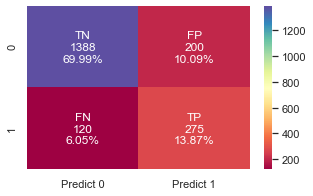

No Skill: ROC AUC=0.500
Model: ROC AUC=0.875


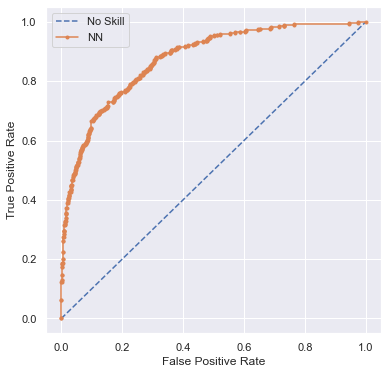

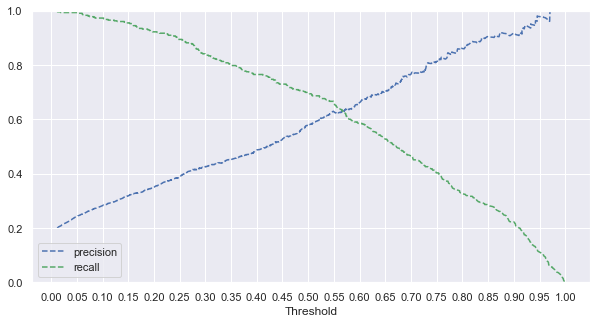

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625


In [175]:
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model, X_val, y_val)
scores.loc[len(scores.index)] = ['NN 13/27 Undersampled X', auc, acc, prec, rec, f1, thr, rec_thr]
scores

Recall is slightly lower compared to model fit on oversampled but still higher than initial model.  

However, AUC score is very similar for all NN models so far.  By varying the threshold, similar scores can be achieved.

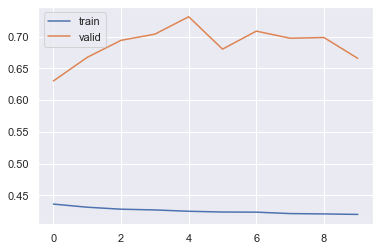

In [176]:
plot_loss_by_epoch(history)

Try with higher number of epochs against initial model (13/27 hidden layers and train on X_train)

In [177]:
create_model(model_layers_13_27)
history = model.fit(X_train, y_train, epochs=20,validation_split=0.2)

Epoch 1/20
149/149 [==============================] - 0s 2ms/step - loss: 0.3247 - recall_10: 0.5021 - val_loss: 0.3885 - val_recall_10: 0.4080
Epoch 2/20
149/149 [==============================] - 0s 2ms/step - loss: 0.3184 - recall_10: 0.4808 - val_loss: 0.3892 - val_recall_10: 0.4480
Epoch 3/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3166 - recall_10: 0.4872 - val_loss: 0.3913 - val_recall_10: 0.4880
Epoch 4/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3154 - recall_10: 0.5043 - val_loss: 0.3908 - val_recall_10: 0.3960
Epoch 5/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3150 - recall_10: 0.4968 - val_loss: 0.3908 - val_recall_10: 0.4480
Epoch 6/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3141 - recall_10: 0.4947 - val_loss: 0.3943 - val_recall_10: 0.4560
Epoch 7/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3145 - recall_10: 0.5032 - val_loss: 0.3913 - val_recall_10:

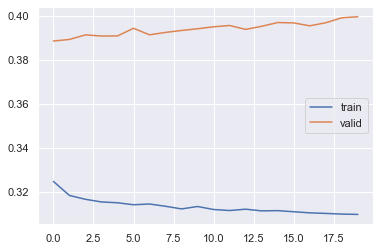

In [178]:
plot_loss_by_epoch(history)

62/62 [==============================] - 0s 917us/step - loss: 0.3252 - recall_10: 0.4380

Accuracy=0.867 - Precision=0.808 - Recall=0.438 - F1 Score=0.568


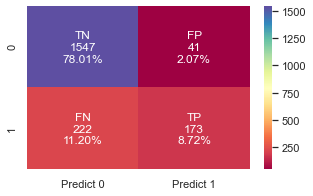

No Skill: ROC AUC=0.500
Model: ROC AUC=0.875


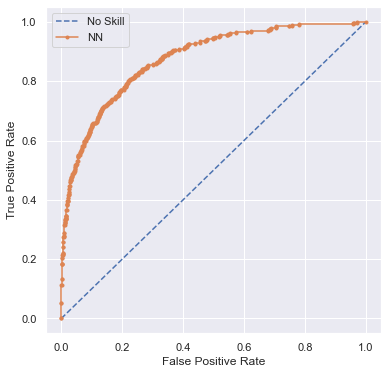

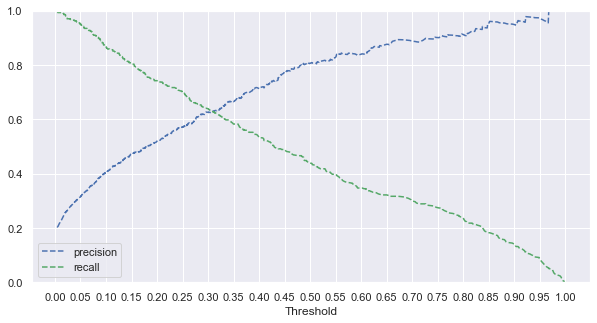

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625
3,NN 13/27 X_Train - 20 Epochs,0.875,0.867,0.808,0.438,0.568,0.307,0.628


In [179]:
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model, X_val, y_val)
scores.loc[len(scores.index)] = ['NN 13/27 X_Train - 20 Epochs', auc, acc, prec, rec, f1, thr, rec_thr]
scores

Recall is slightly higher than first NN model but at the cost of precision.

Try to change the number of neurons in hidden layers.

In [180]:
model_layers_27_100 = [
    Dense(units=27, input_shape=(X_train.shape[1],) , activation='relu'),
    Dense(100, activation='relu'),
    Dense(1, activation=tf.keras.activations.sigmoid)
]

create_model(model_layers_27_100)
history = model.fit(X_train, y_train, epochs=20,validation_split=0.2, verbose=0)

62/62 [==============================] - 0s 888us/step - loss: 0.3247 - recall_10: 0.4835

Accuracy=0.866 - Precision=0.755 - Recall=0.484 - F1 Score=0.590


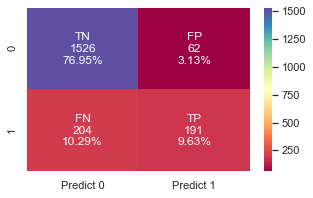

No Skill: ROC AUC=0.500
Model: ROC AUC=0.875


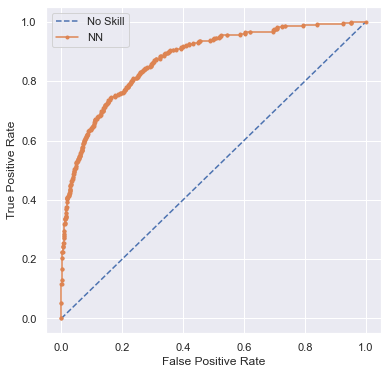

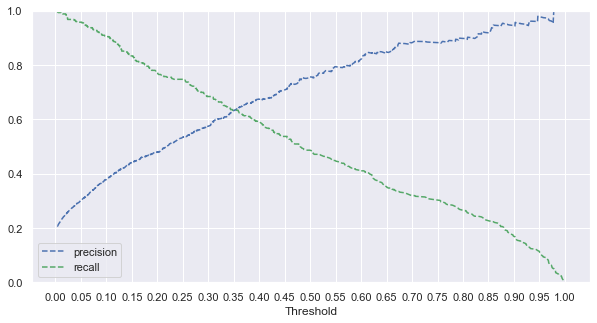

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625
3,NN 13/27 X_Train - 20 Epochs,0.875,0.867,0.808,0.438,0.568,0.307,0.628
4,NN 27/100 - 20 Epochs,0.875,0.866,0.755,0.484,0.590,0.352,0.633


In [181]:
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model, X_val, y_val)
scores.loc[len(scores.index)] = ['NN 27/100 - 20 Epochs', auc, acc, prec, rec, f1, thr, rec_thr]
scores

No gains compared to the previous networks.

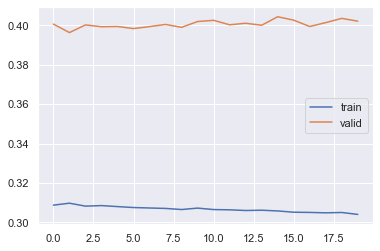

In [182]:
plot_loss_by_epoch(history)

As the target class is imbalanced, we will test using class_weight to compensate for the imbalance.

In [183]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(y_train), 
                                                  y=np.array([y_train.iloc[i] for i in range(len(y_train))]))
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.6245013646861222, 1: 2.508010118043845}

In [184]:
create_model(model_layers_27_100)
history = model.fit(X_train,y_train,batch_size=15,epochs=10, class_weight=class_weights, validation_split=0.2,shuffle=True)

Epoch 1/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4312 - recall_10: 0.7788 - val_loss: 0.4995 - val_recall_10: 0.6600
Epoch 2/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4204 - recall_10: 0.7788 - val_loss: 0.5300 - val_recall_10: 0.7080
Epoch 3/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4180 - recall_10: 0.7959 - val_loss: 0.4781 - val_recall_10: 0.6200
Epoch 4/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4160 - recall_10: 0.7831 - val_loss: 0.4942 - val_recall_10: 0.6560
Epoch 5/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4136 - recall_10: 0.7863 - val_loss: 0.5464 - val_recall_10: 0.7200
Epoch 6/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4128 - recall_10: 0.7949 - val_loss: 0.4956 - val_recall_10: 0.6480
Epoch 7/10
318/318 [==============================] - 1s 2ms/step - loss: 0.4144 - recall_10: 0.7959 - val_loss: 0.4840 - val_recall_10:

62/62 [==============================] - 0s 763us/step - loss: 0.4619 - recall_10: 0.7823

Accuracy=0.773 - Precision=0.459 - Recall=0.782 - F1 Score=0.579


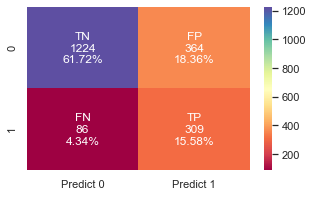

No Skill: ROC AUC=0.500
Model: ROC AUC=0.870


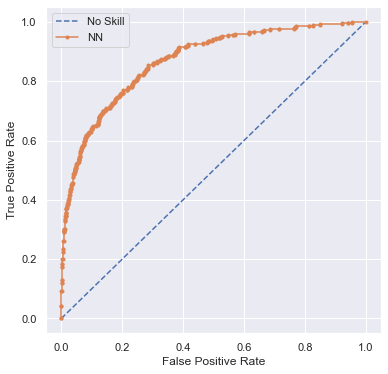

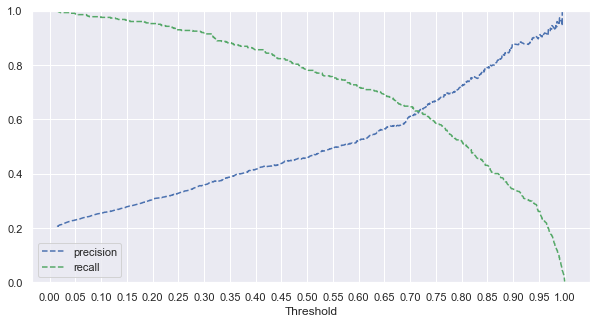

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625
3,NN 13/27 X_Train - 20 Epochs,0.875,0.867,0.808,0.438,0.568,0.307,0.628
4,NN 27/100 - 20 Epochs,0.875,0.866,0.755,0.484,0.590,0.352,0.633
5,NN 27/100 - 10 Ep + class_weights,0.870,0.773,0.459,0.782,0.579,0.716,0.628


In [185]:
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model, X_val, y_val)
scores.loc[len(scores.index)] = ['NN 27/100 - 10 Ep + class_weights', auc, acc, prec, rec, f1, thr, rec_thr]
scores

AUC is not improved compared to previous models.
Recall with default threshold is higher but again at the cost of precision.

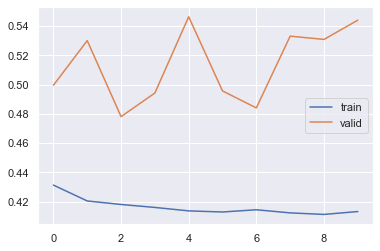

In [186]:
plot_loss_by_epoch(history)

Trying with Dropout layers and different kernel initializer.

In [187]:
# Tune weight initialization and add drop layers
from tensorflow.keras.layers import Dropout

# early stopping callback
es= tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=15,
                             verbose=0, mode='min', restore_best_weights= True)
model2 = Sequential()
# Initialize the weights using hue_normal 
model2.add(Dense(65, input_shape=(X_train.shape[1], ), kernel_initializer='he_normal', activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(65, kernel_initializer='he_normal', activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1, kernel_initializer='he_normal', activation='sigmoid'))

recall_metric = tf.keras.metrics.Recall()

model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), 
               loss='binary_crossentropy', 
               metrics=[recall_metric])
    
his_mod2 = model2.fit(X_train, y_train, 
                     validation_split=0.2, 
                     batch_size=700, 
                     epochs=20, 
                     callbacks=[es], 
                     shuffle=True, 
                     class_weight=class_weights)


Epoch 1/20
7/7 [==============================] - 1s 29ms/step - loss: 0.9956 - recall_14: 0.4818 - val_loss: 0.6771 - val_recall_14: 0.5640
Epoch 2/20
7/7 [==============================] - 0s 6ms/step - loss: 0.9031 - recall_14: 0.5673 - val_loss: 0.6739 - val_recall_14: 0.6920
Epoch 3/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8723 - recall_14: 0.5598 - val_loss: 0.6572 - val_recall_14: 0.6880
Epoch 4/20
7/7 [==============================] - 0s 7ms/step - loss: 0.8162 - recall_14: 0.5737 - val_loss: 0.6350 - val_recall_14: 0.6800
Epoch 5/20
7/7 [==============================] - 0s 7ms/step - loss: 0.7918 - recall_14: 0.5598 - val_loss: 0.6274 - val_recall_14: 0.6960
Epoch 6/20
7/7 [==============================] - 0s 7ms/step - loss: 0.7666 - recall_14: 0.5609 - val_loss: 0.6312 - val_recall_14: 0.7200
Epoch 7/20
7/7 [==============================] - 0s 7ms/step - loss: 0.7318 - recall_14: 0.6058 - val_loss: 0.6357 - val_recall_14: 0.7400
Epoch 8/20
7/7 [===

62/62 [==============================] - 0s 918us/step - loss: 0.5840 - recall_14: 0.7570

Accuracy=0.699 - Precision=0.374 - Recall=0.757 - F1 Score=0.501


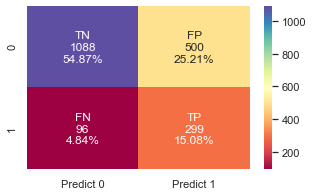

No Skill: ROC AUC=0.500
Model: ROC AUC=0.800


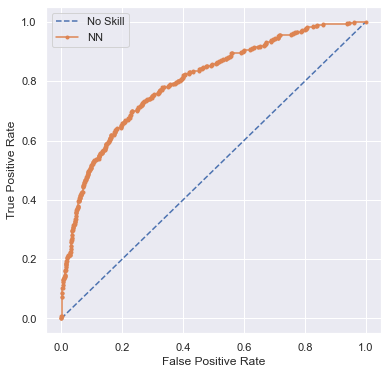

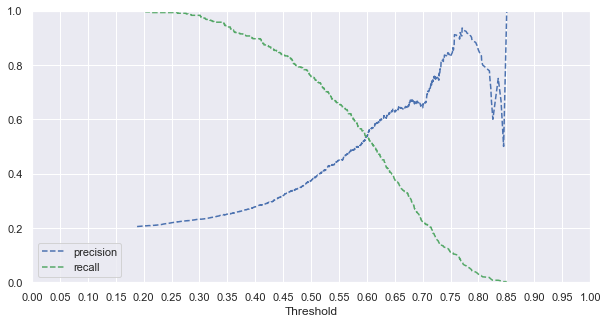

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625
3,NN 13/27 X_Train - 20 Epochs,0.875,0.867,0.808,0.438,0.568,0.307,0.628
4,NN 27/100 - 20 Epochs,0.875,0.866,0.755,0.484,0.590,0.352,0.633
5,NN 27/100 - 10 Ep + class_weights,0.870,0.773,0.459,0.782,0.579,0.716,0.628
6,NN 65/drop/65/drop - 20 Ep + class weights,0.800,0.699,0.374,0.757,0.501,0.600,0.537


In [188]:
#plot metrics
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(model2, X_val, y_val)
scores.loc[len(scores.index)] = ['NN 65/drop/65/drop - 20 Ep + class weights', 
                                 auc, acc, prec, rec, f1, thr, rec_thr]
scores

AUC is lower than all previous models.

The recall with default threshold is > 0.7 but it corresponds to the lowest precision across all models.

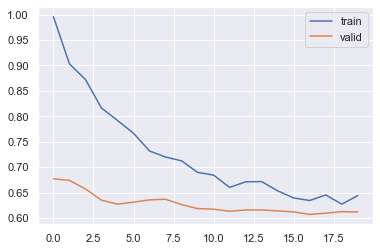

In [189]:
plot_loss_by_epoch(his_mod2)

#### Pick Best model and evaluate performance against test data set
The most performant model based on AUC is 'NN 13/27 Oversampled X', that is the model with two hidden layers with 13 and 27 units trained on oversampled data.  This model also has the best f1-score.

The best performant model based on recall using optimal threshold (threshold where Recall=Precision) is '13/27 Two layers NN'. This model also has best accuracy.

Most models have accuracy > 80%

We will use '13/27 Two layers NN' as the preferred model.

##### Performance against test set

Get new instance of the model and train on X_train.

In [190]:
# get model instance
best_model = create_model(model_layers_13_27)

# train best model on X_train
best_history = best_model.fit(X_train, y_train, epochs=20,validation_split=0.2)

Epoch 1/20
149/149 [==============================] - 1s 2ms/step - loss: 0.3075 - recall_15: 0.5427 - val_loss: 0.4123 - val_recall_15: 0.3920
Epoch 2/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3022 - recall_15: 0.5160 - val_loss: 0.4097 - val_recall_15: 0.4240
Epoch 3/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3025 - recall_15: 0.5150 - val_loss: 0.4125 - val_recall_15: 0.4000
Epoch 4/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3008 - recall_15: 0.5118 - val_loss: 0.4086 - val_recall_15: 0.4400
Epoch 5/20
149/149 [==============================] - 0s 2ms/step - loss: 0.3014 - recall_15: 0.5096 - val_loss: 0.4094 - val_recall_15: 0.4800
Epoch 6/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3008 - recall_15: 0.5214 - val_loss: 0.4087 - val_recall_15: 0.4680
Epoch 7/20
149/149 [==============================] - 0s 1ms/step - loss: 0.3009 - recall_15: 0.5107 - val_loss: 0.4094 - val_recall_15:

Plot metrics against validation set to verify that model has similar performance to the selected one.

62/62 [==============================] - 0s 918us/step - loss: 0.3347 - recall_15: 0.4785

Accuracy=0.862 - Precision=0.738 - Recall=0.478 - F1 Score=0.581


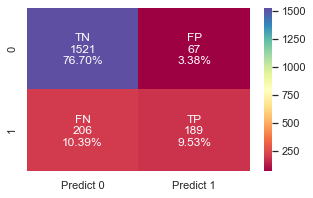

No Skill: ROC AUC=0.500
Model: ROC AUC=0.866


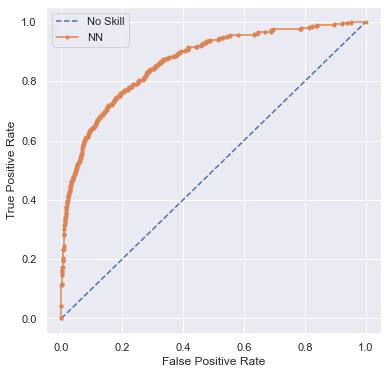

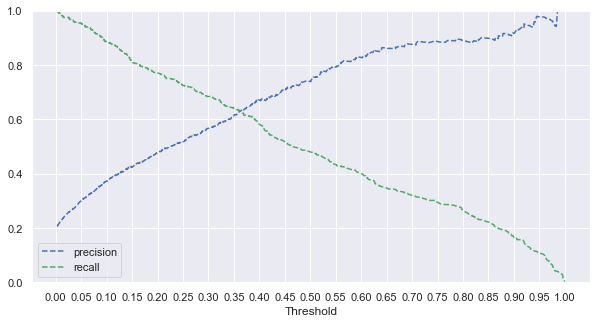

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625
3,NN 13/27 X_Train - 20 Epochs,0.875,0.867,0.808,0.438,0.568,0.307,0.628
4,NN 27/100 - 20 Epochs,0.875,0.866,0.755,0.484,0.590,0.352,0.633
5,NN 27/100 - 10 Ep + class_weights,0.870,0.773,0.459,0.782,0.579,0.716,0.628
6,NN 65/drop/65/drop - 20 Ep + class weights,0.800,0.699,0.374,0.757,0.501,0.600,0.537
7,Best model 13/27 Two layers NN - VALIDATION set,0.866,0.862,0.738,0.478,0.581,0.362,0.630


In [191]:
# Sanity check against validation data
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(best_model, X_val, y_val)
scores.loc[len(scores.index)] = ['Best model 13/27 Two layers NN - VALIDATION set', 
                                 auc, acc, prec, rec, f1, thr, rec_thr]
scores

Get performance on TEST set.

62/62 [==============================] - 0s 1ms/step - loss: 0.3756 - recall_15: 0.4608

Accuracy=0.851 - Precision=0.689 - Recall=0.461 - F1 Score=0.552


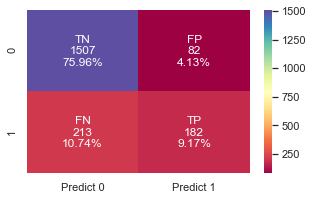

No Skill: ROC AUC=0.500
Model: ROC AUC=0.827


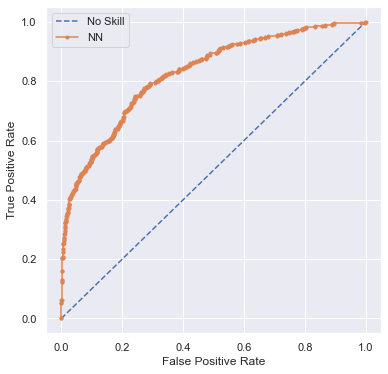

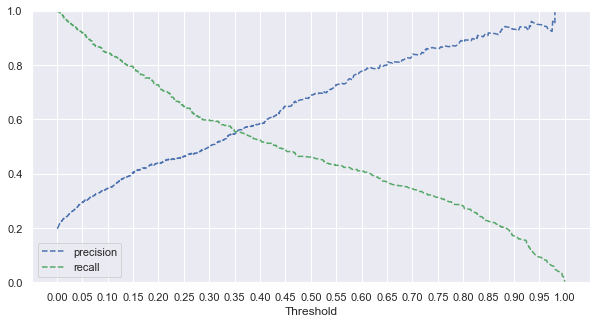

,Model,AUC,Accuracy,Precision,Recall,f1-score,Optimal Threshold,Recall at opt thr
0,13/27 Two layers NN,0.882,0.858,0.705,0.491,0.579,0.389,0.633
1,NN 13/27 Oversampled X,0.881,0.825,0.546,0.711,0.618,0.594,0.641
2,NN 13/27 Undersampled X,0.875,0.839,0.579,0.696,0.632,0.568,0.625
3,NN 13/27 X_Train - 20 Epochs,0.875,0.867,0.808,0.438,0.568,0.307,0.628
4,NN 27/100 - 20 Epochs,0.875,0.866,0.755,0.484,0.590,0.352,0.633
5,NN 27/100 - 10 Ep + class_weights,0.870,0.773,0.459,0.782,0.579,0.716,0.628
6,NN 65/drop/65/drop - 20 Ep + class weights,0.800,0.699,0.374,0.757,0.501,0.600,0.537
7,Best model 13/27 Two layers NN - VALIDATION set,0.866,0.862,0.738,0.478,0.581,0.362,0.630
8,Best model 13/27 Two layers NN - TEST set,0.827,0.851,0.689,0.461,0.552,0.355,0.554


In [192]:
# Performance on TEST set
auc, acc, prec, rec, f1, thr, rec_thr = plot_model_metrics(best_model, X_test, y_test)
scores.loc[len(scores.index)] = ['Best model 13/27 Two layers NN - TEST set', 
                                 auc, acc, prec, rec, f1, thr, rec_thr]
scores

Plot confusion matrix using the optimal threshold (precision=recall) on test

Best Threshold: 0.3550916314125061

Accuracy=0.823 - Precision=0.556 - Recall=0.554 - F1 Score=0.555


(0.8230846774193549,
 0.5558375634517766,
 0.5544303797468354,
 0.5551330798479087)

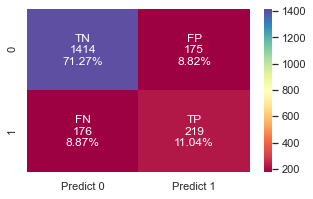

In [193]:
# confusion matrix on TEST set using best threshold
best_threshold = scores.loc[8]['Optimal Threshold']
print('Best Threshold:', best_threshold)
plot_confusion_matrix(best_model, X_test, y_test, threshold=best_threshold)

### Best Model Performance
The performance on test set is:  
* AUC > 0.8, 
* recall with optimal threshold (precision=recall) > 0.5, 
* accuracy > 0.8

The model chosen is slightly overfit.

#### Possible improvements
* Better ways of preprocessing the data
    * Use a better scaler than standard scaler.  StandardScaler() is sensitive to outliers and doesn't preserve the original distribution if it is not gaussian.
    * `Balance` could be broken down in 3 or 4 levels to see if it results in better performance
    * Rather than dropping outliers, instead cap or impute mean/median which might yield better results.  
    Alternatively, drop outliers only in the train set rather than prior to splitting the data.
    * `CreditScore` has a peak at the max of the range and outliers at bottom of the range.  
    It might benefit from being broken down into levels (e.g. low, medium, high)
    * `Estimated Salary` has uniform distribution which doesn't seem realistic.  Removing this column might improve the model.
* Hyperparameters tuning
    * test with differrent weights initializations, and loss functions
    * test with different learning rates and epochs
    * test with different optimizers (e.g. SGD)
    * use random or grid search to tune the models
* Threshold
    * predictions could be made with lower thresholds to reduce the number of false negatives (higher recall), at the cost of more false positives (lower precision)

## Conclusions

### Models
We were able to train multiple neural network models against the data to predict whether a customer will leave the bank or not.

Models performance varied but most have an AUC score greater than 0.8 on validation set.

The model picked as best has AUC > 0.8 on the test set.

Using optimal threshold (Precision=Recall) for classification achieves a recall > 0.5.  Higher recall can be achieved with lower threshold at the expense of precision.

### Business recommendations


The neural network models make it difficult to interpret the weights to identify feature importance.

Based on the EDA:
* The higher the age, the more likely that the customer will leave.  Efforts should be made to identify customer segments and have targeted age-aware campaigns to retain more customers.
* Customers with zero balance are less likely to leave the bank.  Here too, efforts should be made to identify customers segments that have non-zero balance and target for retention.
* Customers from Germany are more likely to leave the bank.  A market analysis should be conducted to compare the bank's offerings in Germany against competitors and aim to reduce the offerings gap and promote superior offerings.
* Females are more likely to leave the bank.  Customer segmentation should be performed to identify what other factors influence this rate and target customers with gender-aware campaigns.
* Inactive customers leave at higher rates than active.  Customers who have a downward trend on their activities or are inactive should be targeted for retention.
* Customers who use less products are more likely to leave.  Customers using only 1 product should be targeted in a campaign to raise awareness of the banks offerings and incentivize the use of more products.